In [74]:
# Import relevant packages

from bs4 import BeautifulSoup # For HTML parsing
import requests # Website connections
from time import sleep # To prevent overwhelming the server between connections
from collections import Counter # Keep track of term counts
import pandas as pd # For converting results to a dataframe and creating plots
import numpy as np # For calculation and utils
import re # For retreving information from strings
import matplotlib.pyplot as plt # For data visualization
import seaborn as sns # For data visualization
%matplotlib inline

### Web Scraping Project - Rental market
For this project, I will gather and explore data regarding the rent marketing of two major cities in Canada: Toronto and Vancouver. To gather the data I will scrap the website https://property.ca/. Then, I will use python to explore and analyze the data.

## Data Gathering
The first step is to gather the data from the website.

In [1383]:
# Set a new value for the parameter 'headers' to be used when making a website request to avoid being denied

headers = {
    'authority': 'www.google.com',
    'accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.7',
    'accept-language': 'en-US,en;q=0.9',
    'cache-control': 'max-age=0',
    'user-agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/115.0.0.0 Safari/537.36',
}

In [1384]:
# Test if the website request will work as intended

# Define the page to be scapped
page_url = 'https://property.ca/toronto?mode=Rent'

# Make the request
response = requests.get(page_url, headers=headers)

# Check status code (it should be equal to '200')
response.status_code

200

The website request works as intended. The appropriate request to gather data regarding each unit listed for rent will be used from now on. The data to be retrieved includes the following variables: mls code., address, number of bedrooms, number of bathrooms, number of parking slots, size, broker, time since listed on the website, neighbourhood, region the neighbourhood belongs to, city.

In [1386]:
# The following code can retrieve data regarding the neigbourhood 'Harbourfront' from the city of Toronto

# Define page counter
page_counter = 1

# Set the url to make the request
page_url = f'https://property.ca/toronto/harbourfront/homes-for-rent?page={page_counter}'

# Make the request and retrieve a response
response = requests.get(page_url, headers=headers)

# Parse the response using BeatifulSoup
soup = BeautifulSoup(response.content)

# Retrieve the number of pages associated with the neighbourhood being scrapped
max_page = int(soup.find('div', {'class':"sc-gsnTZi dvdpIz styles___Pagination-sc-y01fe3-1 haewgn"}).find_all('li')[-1].text)

# Set lists to store the information that will be scrapped
prices = []
addresses = []
bedrooms = []
bathrooms = []
parking = []
size = []
brokers = []
mls_codes = []
time_since_listed = []

# Set a loop to allow python to go through the neighbourhood's listed units until there are no more pages associated with the neighbourhood
while page_counter <= max_page:
    page_url = f'https://property.ca/toronto/harbourfront/homes-for-rent?page={page_counter}'
    response = requests.get(page_url, headers=headers)
    soup = BeautifulSoup(response.content)
    price_info = soup.find_all('div', {'class':"styles___AskingPrice-sc-54qk44-4 deOfjO"}) # Gather information regarding price in the page
    address_info = soup.find_all('address', {'class': "styles___Address-sc-54qk44-14 cmDeAo"}) # Gather information regarding address in the page
    unit_info = soup.find_all('div', {'class':"styles___InfoHolder-sc-54qk44-7 cHIyac"}) # Gather information regarding number of bedrooms, bathrooms and parking slots
    broker_info = soup.find_all('div', {'class': "styles___Brokerage-sc-54qk44-12 latzM"}) # Gather information regarding brokers in the page
    mls_info = soup.find_all('div', {'class': "styles___Mls-sc-54qk44-13 bqnExN"}) # Gather information regarding mls code in the page
    time_info = soup.find_all('div', {'class':"styles___ListedDays-sc-54qk44-6 iRAzre"}) # Gather information regarding the time since the units were listed

    for price in price_info: # Append price information to the list 'prices'
        try:
            unit_price = int(price.text.replace('$','').replace(',','')) # Strip out the dollar sing and ',' so the value can be interpreted as int
            prices.append(unit_price)
        except:
            prices.append('Not listed') # If the website doesn't list a price for the unit, the value to append is 'Not listed'
    
    for address in address_info: # Append address information to the list 'addesses'
        try:
            unit_address = address.text
            addresses.append(unit_address)
        except:
            addresses.append('Not listed') # If the website doesn't list an address for the unit, the value to append is 'Not listed'
    
    for unit_info in unit_info: # Append number of bedrooms, bathrooms and parking slots to the lists 'bedrooms', 'bathrooms' and 'partking', respectively
        try:
            info_tuple = re.compile(r'([0-9+]+BD)([0-9]+BA)([0-9]+\sParking)').findall(unit_info.text)[0] # The regex patern retrieves the information to be appended to each list
            beds, baths, park = info_tuple # The first element of the list is a tuple with 3 elements. The first refers to the # of bedrooms, the second to the # of bathrooms, and the third to parking 
            bedrooms.append(beds) 
            bathrooms.append(baths)
            parking.append(park)
        except:
            bedrooms.append('Not listed')  # If the website doesn't list any of these information, the value to append is 'Not listed'
            bathrooms.append('Not listed')
            parking.append('Not listed')
        try: 
            size_info = re.compile(r'([0-9]+?-?[0-9]+?[\s]sqft)$').findall(unit_info.text.replace(',',''))[0] # This regex patern tries to capture information regarding unit size, if any exists
            size.append(size_info)
        except:
            size.append('Not listed') # If the website doesn't list the size of the unit, the value to append is 'Not listed'
    
    for info in broker_info: # Append broker name to the list 'brokers'
        try:
            broker = info.text
            brokers.append(broker)
        except:
            brokers.append('Not listed') # If the website doesn't list the broker, the value to append is 'Not listed'
    
    for mls in mls_info:  # Append mls code to the list 'mls_codes'
        try:
            code = mls.text
            mls_codes.append(code)
        except:
            mls_codes.append('Not listed') # If the website doesn't list the mls code, the value to append is 'Not listed'
    
    for time_stamp in time_info: # Append information regarding the time since the unit was listed on the website to the list 'time_since_listed'
        try:
            time_listed = time_stamp.text
            time_since_listed.append(time_listed)
        except:
            time_since_listed.append('Not listed') # If the website doesn't list the time, the value to append is 'Not listed'

    print(page_counter) # Prints the number of the page after its information has been gathered. This is just to test the code and surveil its execution.
    page_counter += 1 # Sets the loop to request the next page of the units listed for the neighbourhood
    sleep(np.random.randint(10, 21)) # Wait between 10 to 20 seconds to scrap a new page to avoid being denied

1
2
3
4
5
6
7


In [1387]:
df = pd.DataFrame({'mls': mls_codes,
              'address': addresses,
              'price': prices,             
              'bedrooms': bedrooms,
              'bathsrooms': bathrooms,
              'parking': parking,
              'size': size,
              'time_since_listed': time_since_listed,
              'broker': brokers,
             'neigbourhood': 'Harbourfront',
             'region': 'Downtown',
             'city': 'Toronto'})

df

,mls,address,price,bedrooms,bathsrooms,parking,size,time_since_listed,broker,neigbourhood,region,city
0,MLS#: C9305902,2203 - 15 Queens Quay E,3500,2BD,2BA,1 Parking,600-699 sqft,8 days,PROPERTY.CA INC.,Harbourfront,Downtown,Toronto
1,MLS#: C9352060,2401 - 20 Richardson St,2350,1BD,1BA,0 Parking,500-599 sqft,40 minutes,RE/MAX PLUS CITY TEAM INC.,Harbourfront,Downtown,Toronto
2,MLS#: C9351870,1406 - 208 Queens Quay W,2650,1BD,1BA,0 Parking,600-699 sqft,40 minutes,ROYAL LEPAGE YOUR COMMUNITY REALTY,Harbourfront,Downtown,Toronto
3,MLS#: C9351535,620 - 230 Queens Quay W,2500,1BD,1BA,1 Parking,600-699 sqft,40 minutes,FREEMAN REAL ESTATE LTD.,Harbourfront,Downtown,Toronto
4,MLS#: C9351423,1302 - 15 Lower Jarvis St,2400,1BD,1BA,0 Parking,500-599 sqft,40 minutes,SOLDBIG REALTY INC.,Harbourfront,Downtown,Toronto
...,...,...,...,...,...,...,...,...,...,...,...,...
331,MLS#: C8060228,PH207 - 55 Cooper St,3950,1BD,1BA,0 Parking,600-699 sqft,217 days,RE/MAX REALTRON REALTY INC.,Harbourfront,Downtown,Toronto
332,MLS#: C8012382,PH212 - 55 Cooper St,8980,3BD,3BA,0 Parking,1000-1199 sqft,239 days,RE/MAX REALTRON REALTY INC.,Harbourfront,Downtown,Toronto
333,MLS#: C7382954,PH206 - 138 Downes St,9800,3BD,3BA,1 Parking,1000-1199 sqft,253 days,RIGHT AT HOME REALTY,Harbourfront,Downtown,Toronto
334,MLS#: C7382862,PH212 - 138 Downes St,3500,1BD,1BA,0 Parking,500-599 sqft,253 days,RIGHT AT HOME REALTY,Harbourfront,Downtown,Toronto


Given that the code has worked properly, a function to facilitate the data gathering will be created. This function will take neighbourhood and city as arguments and retrieve the data associated with them.

In [1389]:
def get_data(city, neighbourhood):

    '''
    Gather rental data from the website https://property.ca/. It returns a DataFrame regarding the neighbourhood of the city given as arguments
    when the function is called.
    
    Arg:
        city (str): The name of the city.
        neighbourhood (str): The name of the neighbourhood.

    
    Returns:
        Pandas dataframe containinh with the following data:
        mls: the mls number for each unit listed.
        address: address of the unit.
        price: price of the rent per month in canadian dollars.
        bedrooms: number of bedrooms of the the unit.
        bathrooms: number of bathrooms of the the unit.
        parking: number of parking slots of the unit.
        size: size of the unit.
        time_since_listed: the time since the unit has been posted on the website.
        broker: broker responsible for the unit.
        neighbourhood: the name of the neighbourhood the unit belongs to.
        city: the name of the city where the unit is located.
    '''

    city_to_search = city.lower()
    neighbourhood_to_search = neighbourhood.lower()

    # Set a new value for the parameter 'headers' to be used when making a website request to avoid being denied
    headers = {
        'authority': 'www.google.com',
        'accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.7',
        'accept-language': 'en-US,en;q=0.9',
        'cache-control': 'max-age=0',
        'user-agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/115.0.0.0 Safari/537.36',
    }

    # Define page counter
    page_counter = 1
    
    # Set the url to make the request
    page_url = f'https://property.ca/{city_to_search}/{neighbourhood_to_search}/homes-for-rent?page={page_counter}'
    
    # Make the request and retrieve a response
    response = requests.get(page_url, headers=headers)
    
    # Parse the response ussing BeatifulSoup
    soup = BeautifulSoup(response.content)
    
    # Retrieve the number of pages associated with the neighbourhood being scrapped
    max_page = int(soup.find('div', {'class':"sc-gsnTZi dvdpIz styles___Pagination-sc-y01fe3-1 haewgn"}).find_all('li')[-1].text)
    
    # Set lists to store the informations we are going to scappe
    prices = []
    addresses = []
    bedrooms = []
    bathrooms = []
    parking = []
    size = []
    brokers = []
    mls_codes = []
    time_since_listed = []
    
    # Set a loop to allow python to go through the neighbourhood listed units until there are no more pages associated with the neighbourhood
    while page_counter <= max_page:
        page_url = f'https://property.ca/{city_to_search}/{neighbourhood_to_search}/homes-for-rent?page={page_counter}'
        response = requests.get(page_url, headers=headers)
        soup = BeautifulSoup(response.content)
        price_info = soup.find_all('div', {'class':"styles___AskingPrice-sc-54qk44-4 deOfjO"}) # Gather information regarding price in the page
        address_info = soup.find_all('address', {'class': "styles___Address-sc-54qk44-14 cmDeAo"}) # Gather information regarding address in the page
        unit_info = soup.find_all('div', {'class':"styles___InfoHolder-sc-54qk44-7 cHIyac"}) # Gather information regarding # of bedrooms, bathrooms and parking slots
        broker_info = soup.find_all('div', {'class': "styles___Brokerage-sc-54qk44-12 latzM"}) # Gather information regarding brokers in the page
        mls_info = soup.find_all('div', {'class': "styles___Mls-sc-54qk44-13 bqnExN"}) # Gather information regarding price in the page
        time_info = soup.find_all('div', {'class':"styles___ListedDays-sc-54qk44-6 iRAzre"}) # Gather information regarding the time since the units were listed
    
        for price in price_info: # Append price information to the list 'prices'
            try:
                unit_price = int(price.text.replace('$','').replace(',','')) # Stripp out the dollar sing and ',' so the value can be interpreted as int
                prices.append(unit_price)
            except:
                prices.append('Not listed') # If the website doesn't list a price for the unit, the value to append is 'Not listed'
        
        for address in address_info: # Append address information to the list 'addesses'
            try:
                unit_address = address.text
                addresses.append(unit_address)
            except:
                addresses.append('Not listed') # If the website doesn't list an address for the unit, the value to append is 'Not listed'
        
        for unit_info in unit_info: # Append # of bedrooms, bathrooms and parking slots to the lists 'bedrooms', 'bathrooms' and 'partking', respectively
            try:
                info_tuple = re.compile(r'([0-9+]+BD)([0-9]+BA)([0-9]+\sParking)').findall(unit_info.text)[0] # The regex patern retrieves the information to be appended to each list
                beds, baths, park = info_tuple # The first element of the list is a tuple with 3 elements. The first refers to the # of bedrooms, the second to the # of bathrooms, and the third to parking 
                bedrooms.append(beds) 
                bathrooms.append(baths)
                parking.append(park)
            except:
                bedrooms.append('Not listed')  # If the website doesn't list any of these information, the value to append is 'Not listed'
                bathrooms.append('Not listed')
                parking.append('Not listed')
            try: 
                size_info = re.compile(r'([0-9]+?-?[0-9]+?[\s]sqft)$').findall(unit_info.text.replace(',',''))[0] # This regex patern tries to capture information regarding unit size, if any exists
                size.append(size_info)
            except:
                size.append('Not listed') # If the website doesn't list the size of the unit, the value to append is 'Not listed'
        
        for info in broker_info: # Append broker name to the list 'brokers'
            try:
                broker = info.text
                brokers.append(broker)
            except:
                brokers.append('Not listed') # If the website doesn't list the broker, the value to append is 'Not listed'
        
        for mls in mls_info:  # Append mls code to the list 'mls_codes'
            try:
                code = mls.text
                mls_codes.append(code)
            except:
                mls_codes.append('Not listed') # If the website doesn't list the mls code, the value to append is 'Not listed'
        
        for time_stamp in time_info: # Append information regarding the time since the unit was listed on the website to the list 'time_since_listed'
            try:
                time_listed = time_stamp.text
                time_since_listed.append(time_listed)
            except:
                time_since_listed.append('Not listed') # If the website doesn't list the time, the value to append is 'Not listed'
    
        page_counter += 1 # Sets the loop to request the next page of the units listed for the neighbourhood
        sleep(np.random.randint(10, 21)) # Wait between 10 to 20 seconds to scrap a new page to avoid being denied
    
    # Create a data frame using the information gathered       
    df = pd.DataFrame({'mls': mls_codes,
              'address': addresses,
              'price': prices,             
              'bedrooms': bedrooms,
              'bathrooms': bathrooms,
              'parking': parking,
              'size': size,
              'time_since_listed': time_since_listed,
              'broker': brokers,
              'neighbourhood': neighbourhood,
              'city': city})
    print(f'{city}, {neighbourhood}: DataFrame successfully created.')

    # Return the dataframe
    return df

In [1390]:
# Test the function

Harbourfront = get_data(city='Toronto', neighbourhood='Harbourfront')

Harbourfront

Toronto, Harbourfront: DataFrame successfully created.


,mls,address,price,bedrooms,bathrooms,parking,size,time_since_listed,broker,neighbourhood,city
0,MLS#: C9305902,2203 - 15 Queens Quay E,3500,2BD,2BA,1 Parking,600-699 sqft,8 days,PROPERTY.CA INC.,Harbourfront,Toronto
1,MLS#: C9352060,2401 - 20 Richardson St,2350,1BD,1BA,0 Parking,500-599 sqft,40 minutes,RE/MAX PLUS CITY TEAM INC.,Harbourfront,Toronto
2,MLS#: C9351870,1406 - 208 Queens Quay W,2650,1BD,1BA,0 Parking,600-699 sqft,40 minutes,ROYAL LEPAGE YOUR COMMUNITY REALTY,Harbourfront,Toronto
3,MLS#: C9351535,620 - 230 Queens Quay W,2500,1BD,1BA,1 Parking,600-699 sqft,40 minutes,FREEMAN REAL ESTATE LTD.,Harbourfront,Toronto
4,MLS#: C9351423,1302 - 15 Lower Jarvis St,2400,1BD,1BA,0 Parking,500-599 sqft,40 minutes,SOLDBIG REALTY INC.,Harbourfront,Toronto
...,...,...,...,...,...,...,...,...,...,...,...
331,MLS#: C8060228,PH207 - 55 Cooper St,3950,1BD,1BA,0 Parking,600-699 sqft,217 days,RE/MAX REALTRON REALTY INC.,Harbourfront,Toronto
332,MLS#: C8012382,PH212 - 55 Cooper St,8980,3BD,3BA,0 Parking,1000-1199 sqft,239 days,RE/MAX REALTRON REALTY INC.,Harbourfront,Toronto
333,MLS#: C7382954,PH206 - 138 Downes St,9800,3BD,3BA,1 Parking,1000-1199 sqft,253 days,RIGHT AT HOME REALTY,Harbourfront,Toronto
334,MLS#: C7382862,PH212 - 138 Downes St,3500,1BD,1BA,0 Parking,500-599 sqft,253 days,RIGHT AT HOME REALTY,Harbourfront,Toronto


In [1391]:
weston = get_data(city='Toronto', neighbourhood='Weston')
weston

Toronto, Weston: DataFrame successfully created.


,mls,address,price,bedrooms,bathrooms,parking,size,time_since_listed,broker,neighbourhood,city
0,MLS#: W9351338,321 - 2464 Weston Rd W,1950,Not listed,Not listed,Not listed,0-499 sqft,45 minutes,SHEL REALTY INC.,Weston,Toronto
1,MLS#: W9350012,Main Fl - 4 Coulter Ave,2300,2BD,1BA,1 Parking,Not listed,1 day,ROYAL LEPAGE PREMIUM ONE REALTY,Weston,Toronto
2,MLS#: W9346014,Bsmt - 95 Touchstone Dr,2000,1BD,1BA,0 Parking,Not listed,3 days,ROYAL LEPAGE IGNITE REALTY,Weston,Toronto
3,MLS#: W9350161,13 - 23 Rivers Edge Dr,2999,3BD,2BA,2 Parking,1000-1199 sqft,6 days,PROPERTY MAX REALTY INC.,Weston,Toronto
4,MLS#: W9308544,2nd Flr - 1896 Jane St,2500,2BD,1BA,0 Parking,Not listed,6 days,SOURCE 4 REALTY INC.,Weston,Toronto
5,MLS#: W9307863,Upper - 10 Creekbank Rd,2400,2BD,2BA,1 Parking,700-1100 sqft,6 days,ROYAL ESTATE REALTY POINT,Weston,Toronto
6,MLS#: W9302408,9 Piggott Mews,3500,3BD,2BA,2 Parking,Not listed,10 days,RIGHT AT HOME REALTY,Weston,Toronto
7,MLS#: W9302700,402 - 10 Wilby Cres,2650,1BD,2BA,1 Parking,700-799 sqft,10 days,HOMELIFE/MIRACLE REALTY LTD,Weston,Toronto
8,MLS#: W9299537,Upper - 3 Wild Rose Gdns,2300,2BD,2BA,0 Parking,Not listed,11 days,KAMALI GROUP REALTY,Weston,Toronto
9,MLS#: C9294343,703 - 224 King St,3480,2BD,2BA,0 Parking,900-999 sqft,14 days,RE/MAX ELITE REAL ESTATE,Weston,Toronto


The function works properly and can be used to retrieved the data required for analysis

In [1393]:
# Define lists containing neighbourhoods listed on the website per each region of Toronto. The name of each neighbourhood has to be the same
# as the name listed when a url request is made.

toronto_downtown = ['king-west', 
                    'harbourfront', 
                    'bay-st-corridor', 
                    'church-st-corridor', 
                    'yonge-and-bloor', 
                    'queen-west', 
                    'st-lawrence', 
                    'yorkville', 
                    'financial-district', 
                    'cityplace',
                    'cabbagetown',
                    'fort-york', 
                    'regent-park', 
                    'grange-park']

toronto_north_york = ['willowdale', 
                      'bayview-village', 
                      'newtonbrook', 
                      'downsview', 
                      'henry-farm', 
                      'wilson-heights', 
                      'st-andrew-york-mills', 
                      'banbury-don-mills',
                      'the-peanut',
                      'amesbury',
                      'university-heights',
                      'lansing',
                      'parkwoods',
                      'yorkdale']

toronto_scarborough = ['scarborough-town-centre',
                       'lamoreaux', 
                       'agincourt',
                       'malvern', 
                       'west-hill',
                       'bluffs',
                       'scarborough-junction',
                       'wexford-maryvale',
                       'birch-cliff',
                       'dorset-park',
                       'milliken-park', 
                       'clairlea',
                       'oakridge', 
                       'rouge']

toronto_etobicoke = ['mimico', 
                     'islington-city-centre-west', 
                     'west-humber-clairville', 
                     'stonegate-queensway',
                     'long-branch',
                     'scarborough-village',
                     'edenbridge-humber-valley',
                     'new-toronto', 'richview',
                     'alderwood', 'humber-heights',
                     'eringate-centennial-west-deane', 
                     'kingsview-village',
                     'markland-wood']

toronto_midtown = ['yonge-and-eglinton',
                   'humewood-cedarvale',
                   'mount-pleasant',
                   'carleton-village',
                   'deer-park',
                   'forest-hill',
                   'davisville-village',
                   'corso-italia',
                   'lytton-park',
                   'casa-loma',
                   'rosedale',
                   'summerhill',
                   'hillcrest-bracondale-hill',
                   'lawrence-park']

toronto_west_end = ['liberty-village', 
                    'swansea', 
                    'beaconsfield-village', 
                    'parkdale',
                    'seaton-village',
                    'trinity-bellwoods',
                    'the-junction',
                    'high-park', 
                    'junction-triangle', 
                    'roncesvalles-village',
                    'dufferin-grove', 
                    'little-italy',
                    'dovercourt-park',
                    'wallace-emerson']

toronto_east_york = ['east-york/east-york-neighbourhood',
                     'flemingdon-park',
                     'leaside', 
                     'st-clair-oconnor',
                     'victoria-village', 
                     'the-danforth', 
                     'thorncliffe-park',
                     'playter-estates', 
                     'todmorden-village']

toronto_east_end = ['leslieville',
                    'the-beach', 
                    'main-danforth-danforth-village',
                    'upper-beaches-woodbine-corridor',
                    'riverside',
                    'riverdale',
                    'little-india',
                    'blake-jones',
                    'woodbine-lumsden',
                    'the-pocket',
                    'greenwood-coxwell']

toronto_york_crosstown = ['weston', 
                         'rockcliffe-smythe',
                         'fairbank',
                         'keelesdale', 
                         'lambton']

# Define lists containing neighbourhoods listed on the website per each region of Vancouver. The name of each neighbourhood has to be the same
# as the name listed when a url request is made

vancouver_central = ['downtown', 
                     'yaletown', 
                     'gastown', 
                     'west-end', 
                     'downtown-eastside',
                     'coal-harbour',
                     'davie-village']

vancouver_east_side = ['renfrew-collingwood',
                       'kensington-cedar-cottage',
                       'mount-pleasant',
                       'riley-park',
                       'hastings-sunrise', 
                       'grandview-woodland', 
                       'strathcona']

vancouver_west_side = ['university',
                       'dunbar-southlands', 
                       'fairview',
                       'south-cambie', 
                       'kitsilano', 
                       'arbutus-ridge', 
                       'shaughnessy', 
                       'west-point-grey', 
                       'false-creek']

vancouver_south_vancouver = ['marpole', 
                             'kerrisdale', 
                             'oakridge', 
                             'killarney',
                             'sunset', 
                             'victoria-fraserview']


# Unite the lists for each city
toronto = []

for i in [toronto_downtown,
          toronto_north_york, 
          toronto_etobicoke, 
          toronto_midtown, 
          toronto_west_end, 
          toronto_east_york,
          toronto_east_end, 
          toronto_york_crosstown]:
    toronto.extend(i)

vancouver = []

for i in [vancouver_central,
          vancouver_east_side,
          vancouver_west_side,
          vancouver_south_vancouver]:
    vancouver.extend(i)

In [1394]:
# Check if it worked 

vancouver

['downtown',
 'yaletown',
 'gastown',
 'west-end',
 'downtown-eastside',
 'coal-harbour',
 'davie-village',
 'renfrew-collingwood',
 'kensington-cedar-cottage',
 'mount-pleasant',
 'riley-park',
 'hastings-sunrise',
 'grandview-woodland',
 'strathcona',
 'university',
 'dunbar-southlands',
 'fairview',
 'south-cambie',
 'kitsilano',
 'arbutus-ridge',
 'shaughnessy',
 'west-point-grey',
 'false-creek',
 'marpole',
 'kerrisdale',
 'oakridge',
 'killarney',
 'sunset',
 'victoria-fraserview']

In [1395]:
# Create an empty list to store the data of each neighbourhood of Toronto
toronto_neighbourhoods_dfs = []

# Use the function get_data() to gather data from all neighbourhoods listed for the city of Toronto
for var in toronto:
    try:
        neighbourhood_df = get_data(city='Toronto', neighbourhood=var)
        toronto_neighbourhoods_dfs.append(neighbourhood_df)
    except:
        print(f'Toronto, {var}: failed to create DataFrame.')

Toronto, king-west: DataFrame successfully created.
Toronto, harbourfront: DataFrame successfully created.
Toronto, bay-st-corridor: DataFrame successfully created.
Toronto, church-st-corridor: DataFrame successfully created.
Toronto, yonge-and-bloor: DataFrame successfully created.
Toronto, queen-west: DataFrame successfully created.
Toronto, st-lawrence: DataFrame successfully created.
Toronto, yorkville: DataFrame successfully created.
Toronto, financial-district: DataFrame successfully created.
Toronto, cityplace: DataFrame successfully created.
Toronto, cabbagetown: DataFrame successfully created.
Toronto, fort-york: DataFrame successfully created.
Toronto, regent-park: DataFrame successfully created.
Toronto, grange-park: DataFrame successfully created.
Toronto, willowdale: DataFrame successfully created.
Toronto, bayview-village: DataFrame successfully created.
Toronto, newtonbrook: DataFrame successfully created.
Toronto, downsview: DataFrame successfully created.
Toronto, henr

In [1396]:
# Repeat the proccess for the city of Vancouver

# Create an empty list to store the data of each neighbourhood of Vancouver
vancouver_neighbourhoods_dfs = []

# Use the function get_data() to gather data from all neighbourhoods listed for the city of Vancouver
for var in vancouver:
    try:
        neighbourhood_df = get_data(city='Vancouver', neighbourhood=var)
        vancouver_neighbourhoods_dfs.append(neighbourhood_df)
    except:
        print(f'Vancouver, {var}: failed to create DataFrame.')

Vancouver, downtown: DataFrame successfully created.
Vancouver, yaletown: DataFrame successfully created.
Vancouver, gastown: DataFrame successfully created.
Vancouver, west-end: DataFrame successfully created.
Vancouver, downtown-eastside: DataFrame successfully created.
Vancouver, coal-harbour: DataFrame successfully created.
Vancouver, davie-village: DataFrame successfully created.
Vancouver, renfrew-collingwood: DataFrame successfully created.
Vancouver, kensington-cedar-cottage: DataFrame successfully created.
Vancouver, mount-pleasant: DataFrame successfully created.
Vancouver, riley-park: DataFrame successfully created.
Vancouver, hastings-sunrise: DataFrame successfully created.
Vancouver, grandview-woodland: failed to create DataFrame.
Vancouver, strathcona: DataFrame successfully created.
Vancouver, university: DataFrame successfully created.
Vancouver, dunbar-southlands: DataFrame successfully created.
Vancouver, fairview: DataFrame successfully created.
Vancouver, south-cam

In [1397]:
# United the DataFrames in the list 'toronto_neighbourhoods_dfs' to create an unique DataFrame containing Toronto rental data

toronto_rental_data = pd.concat(toronto_neighbourhoods_dfs)
toronto_rental_data.head()

,mls,address,price,bedrooms,bathrooms,parking,size,time_since_listed,broker,neighbourhood,city
0,MLS#: C9350863,D - 32 Shank St,3500,2BD,3BA,2 Parking,1200-1399 sqft,15 minutes,LIVING REALTY INC.,king-west,Toronto
1,MLS#: C9347984,3713 - 35 Mercer St,2450,1BD,1BA,0 Parking,0-499 sqft,2 days,PROPERTY.CA INC.,king-west,Toronto
2,MLS#: C9350769,1508 - 8 Charlotte St,2450,1BD,1BA,0 Parking,500-599 sqft,15 minutes,LIVING REALTY INC.,king-west,Toronto
3,MLS#: C9352026,3204 - 327 King St W,2350,1BD,1BA,0 Parking,0-499 sqft,45 minutes,RE/MAX PLUS CITY TEAM INC.,king-west,Toronto
4,MLS#: C9351633,1013 - 1030 King St W,3600,2BD,2BA,1 Parking,600-699 sqft,45 minutes,RE/MAX EXCEL TITAN,king-west,Toronto


In [1398]:
# Add data regarding the region each neighbourhood belongs to using the listed created previously

# Create an empty list to store the values
toronto_region = []

# Create the values for region by mapping the values of the column 'neighbourhood' to their respective regions
for i in toronto_rental_data['neighbourhood']:
    if i in toronto_downtown:
        toronto_region.append('Downtown')
    elif i in toronto_north_york:
        toronto_region.append('North York')
    elif i in toronto_etobicoke:
        toronto_region.append('Etobicoke')
    elif i in toronto_midtown:
        toronto_region.append('Midtown')
    elif i in toronto_west_end:
        toronto_region.append('West End')
    elif i in toronto_east_york:
        toronto_region.append('East York')
    elif i in toronto_east_end:
        toronto_region.append('East End')
    elif i in toronto_york_crosstown:
        toronto_region.append('York-Crosstown')

# Use these values to create a new columns in the dataset called 'region'
toronto_rental_data['region'] = toronto_region

# Check if it worked
print(toronto_rental_data.head())
print(toronto_rental_data['region'].unique())

              mls                address  price bedrooms bathrooms    parking  \
0  MLS#: C9350863        D - 32 Shank St   3500      2BD       3BA  2 Parking   
1  MLS#: C9347984    3713 - 35 Mercer St   2450      1BD       1BA  0 Parking   
2  MLS#: C9350769  1508 - 8 Charlotte St   2450      1BD       1BA  0 Parking   
3  MLS#: C9352026   3204 - 327 King St W   2350      1BD       1BA  0 Parking   
4  MLS#: C9351633  1013 - 1030 King St W   3600      2BD       2BA  1 Parking   

             size time_since_listed                      broker neighbourhood  \
0  1200-1399 sqft        15 minutes          LIVING REALTY INC.     king-west   
1      0-499 sqft            2 days            PROPERTY.CA INC.     king-west   
2    500-599 sqft        15 minutes          LIVING REALTY INC.     king-west   
3      0-499 sqft        45 minutes  RE/MAX PLUS CITY TEAM INC.     king-west   
4    600-699 sqft        45 minutes          RE/MAX EXCEL TITAN     king-west   

      city    region  
0  

In [1399]:
# United the DataFrames in the list 'vancouver_neighbourhoods_dfs' to create an unique DataFrame containing Vancouver rental data

vancouver_rental_data = pd.concat(vancouver_neighbourhoods_dfs)

# Add data regarding the region each neighbourhood belongs to using the listed created previously

# Create an empty list to store the values
vancouver_region = []

# Create the values for region by mapping the values of the column 'neighbourhood' to their respective regions
for i in vancouver_rental_data['neighbourhood']:
    if i in vancouver_central:
        vancouver_region.append('Central')
    elif i in vancouver_east_side:
        vancouver_region.append('East Side')
    elif i in vancouver_west_side:
        vancouver_region.append('West Side')
    elif i in vancouver_south_vancouver:
        vancouver_region.append('South Vancouver')

# Use these calues to create a new columns in the dataset called 'region'
vancouver_rental_data['region'] = vancouver_region

# Inspect resulting DataFrame
vancouver_rental_data.head()

,mls,address,price,bedrooms,bathrooms,parking,size,time_since_listed,broker,neighbourhood,city,region
0,MLS#: R2925693,3708 - 1283 HOWE STREET,5000,2BD,2BA,0 Parking,Not listed,6 hours,Engel & Volkers Vancouver,downtown,Vancouver,Central
1,MLS#: R2925425,2003 - 610 GRANVILLE STREET,2600,1BD,1BA,0 Parking,Not listed,3 days,Sincere Real Estate Services,downtown,Vancouver,Central
2,MLS#: R2924873,2503 - 438 SEYMOUR STREET,3200,2BD,2BA,1 Parking,Not listed,4 days,Vancouver Luxury Realty,downtown,Vancouver,Central
3,MLS#: R2924728,2803 - 550 TAYLOR STREET,4000,2BD,2BA,1 Parking,Not listed,4 days,Orca Realty Inc.,downtown,Vancouver,Central
4,MLS#: R2924536,188 KEEFER PLACE,2500,1BD,1BA,1 Parking,Not listed,5 days,Inmax Realty,downtown,Vancouver,Central


In [1400]:
# Unite toronto_rental_data and vancouver_rental_data to create 'rental_data
rental_data = pd.concat([toronto_rental_data, vancouver_rental_data])
rental_data

,mls,address,price,bedrooms,bathrooms,parking,size,time_since_listed,broker,neighbourhood,city,region
0,MLS#: C9350863,D - 32 Shank St,3500,2BD,3BA,2 Parking,1200-1399 sqft,15 minutes,LIVING REALTY INC.,king-west,Toronto,Downtown
1,MLS#: C9347984,3713 - 35 Mercer St,2450,1BD,1BA,0 Parking,0-499 sqft,2 days,PROPERTY.CA INC.,king-west,Toronto,Downtown
2,MLS#: C9350769,1508 - 8 Charlotte St,2450,1BD,1BA,0 Parking,500-599 sqft,15 minutes,LIVING REALTY INC.,king-west,Toronto,Downtown
3,MLS#: C9352026,3204 - 327 King St W,2350,1BD,1BA,0 Parking,0-499 sqft,45 minutes,RE/MAX PLUS CITY TEAM INC.,king-west,Toronto,Downtown
4,MLS#: C9351633,1013 - 1030 King St W,3600,2BD,2BA,1 Parking,600-699 sqft,45 minutes,RE/MAX EXCEL TITAN,king-west,Toronto,Downtown
...,...,...,...,...,...,...,...,...,...,...,...,...
3,MLS#: R2903052,1829 SW MARINE DRIVE,6750,4BD,3BA,5 Parking,Not listed,70 days,Engel & Volkers Vancouver,kerrisdale,Vancouver,South Vancouver
0,MLS#: R2926081,107 - 6677 CAMBIE STREET,2700,1BD,1BA,0 Parking,Not listed,1 hour,Sincere Real Estate Services,oakridge,Vancouver,South Vancouver
0,MLS#: R2911369,3548 SAWMILL CRESCENT,3595,2BD,2BA,1 Parking,Not listed,46 days,Vancouver Luxury Realty,killarney,Vancouver,South Vancouver
0,MLS#: R2923323,bsmnt - 568 E 51ST AVENUE,2575,2BD,1BA,0 Parking,Not listed,6 days,Royal LePage Sterling Realty,sunset,Vancouver,South Vancouver


### Saving the dataset locally

In [1401]:
# Save the rental_data to a file, so it can be retrieved easily in the future and there is no need to rescrap the data to recreate the dataset
# if the notebook is closed.

rental_data.to_csv('rental_data_propertyca.csv', index=False) # Drop index
rental_data.to_csv('rental_data_propertyca_with_original_index.csv', index_label='original_index_inside_neighbourhood')

### Loading the dataset based on the local file

In [76]:
# Read the data from the csv file to check if it worked.
data = pd.read_csv('rental_data_propertyca.csv')

# Inspect the first few rows of the data
data.head(10)

,mls,address,price,bedrooms,bathrooms,parking,size,time_since_listed,broker,neighbourhood,city,region
0,MLS#: C9350863,D - 32 Shank St,3500,2BD,3BA,2 Parking,1200-1399 sqft,15 minutes,LIVING REALTY INC.,king-west,Toronto,Downtown
1,MLS#: C9347984,3713 - 35 Mercer St,2450,1BD,1BA,0 Parking,0-499 sqft,2 days,PROPERTY.CA INC.,king-west,Toronto,Downtown
2,MLS#: C9350769,1508 - 8 Charlotte St,2450,1BD,1BA,0 Parking,500-599 sqft,15 minutes,LIVING REALTY INC.,king-west,Toronto,Downtown
3,MLS#: C9352026,3204 - 327 King St W,2350,1BD,1BA,0 Parking,0-499 sqft,45 minutes,RE/MAX PLUS CITY TEAM INC.,king-west,Toronto,Downtown
4,MLS#: C9351633,1013 - 1030 King St W,3600,2BD,2BA,1 Parking,600-699 sqft,45 minutes,RE/MAX EXCEL TITAN,king-west,Toronto,Downtown
5,MLS#: C9351614,4802 - 300 Front St W,5700,2BD,3BA,2 Parking,1400-1599 sqft,45 minutes,ROYAL LEPAGE TERREQUITY PLATINUM REALTY,king-west,Toronto,Downtown
6,MLS#: C9349103,3206 - 80 John St,2850,1+1BD,1BA,0 Parking,600-699 sqft,2 days,PROPERTY.CA INC.,king-west,Toronto,Downtown
7,MLS#: C9351290,706 - 700 King St W,3150,2BD,2BA,1 Parking,800-899 sqft,45 minutes,ROYAL LEPAGE SIGNATURE REALTY,king-west,Toronto,Downtown
8,MLS#: C9350900,1114 - 801 King St W,2400,1BD,1BA,1 Parking,600-699 sqft,45 minutes,RE/MAX ULTIMATE REALTY INC.,king-west,Toronto,Downtown
9,MLS#: C9350458,2902 - 11 Charlotte St,3900,2BD,2BA,1 Parking,800-899 sqft,1 day,KELLER WILLIAMS REFERRED URBAN PIERRE CARAPETI...,king-west,Toronto,Downtown


## Data Dictionary

**mls:** contains the mls number for each unit listed. The mls number is a unique number to identify a property in the canadian real state market.\
**address:** address of the unit.\
**price:** price of the rent per month in canadian dollars.\
**bedrooms:** number of bedrooms the unit has.\
**bathrooms:** number of bathrooms the unit has.\
**parking:** number of parking slots the unit has.\
**size:** size of the unit.\
**time_since_listed:** the time since the unit has been posted on the website.\
**broker:** broker responsible for the unit.\
**neighbourhood:** the name of the neighbourhood the unit belongs to.\
**city:** the name of the city where the unit is located.\
**region:** the region of the city where the unit is located.

## Data Cleaning
Now that the data has been gathered it is necessary to perform data cleaning in order to prepare it for analysis.

#### 1. **Remove duplicates**
    We will start by removing duplicated entries. For this, it is possible to use the mls number, as a property is supposed to be identified by an unique msl number.

In [80]:
# Check the number of duplicates using the 'mls' columns as reference
print("# of duplicated rows based of mls: ", sum(data.duplicated('mls')))

#Inspect some of the duplicated rows
data[data.duplicated('mls', keep=False)].head(10)

# of duplicated rows based of mls:  203


,mls,address,price,bedrooms,bathrooms,parking,size,time_since_listed,broker,neighbourhood,city,region
1,MLS#: C9347984,3713 - 35 Mercer St,2450,1BD,1BA,0 Parking,0-499 sqft,2 days,PROPERTY.CA INC.,king-west,Toronto,Downtown
6,MLS#: C9349103,3206 - 80 John St,2850,1+1BD,1BA,0 Parking,600-699 sqft,2 days,PROPERTY.CA INC.,king-west,Toronto,Downtown
14,MLS#: C9307163,511 - 38 Niagara St,2500,1BD,1BA,0 Parking,500-599 sqft,6 days,PROPERTY.CA INC.,king-west,Toronto,Downtown
22,MLS#: C9253109,1611 - 21 Widmer St,3750,2BD,2BA,1 Parking,800-899 sqft,33 days,PROPERTY.CA INC.,king-west,Toronto,Downtown
30,MLS#: C9269867,1001 - 75 Portland St,3500,1BD,1BA,1 Parking,700-799 sqft,20 days,PROPERTY.CA INC.,king-west,Toronto,Downtown
36,MLS#: C9299516,507 - 66 Portland St,2500,1BD,1BA,0 Parking,500-599 sqft,11 days,PROPERTY.CA INC.,king-west,Toronto,Downtown
53,MLS#: C9307163,511 - 38 Niagara St,2500,1BD,1BA,0 Parking,500-599 sqft,6 days,PROPERTY.CA INC.,king-west,Toronto,Downtown
61,MLS#: C9347984,3713 - 35 Mercer St,2450,1BD,1BA,0 Parking,0-499 sqft,2 days,PROPERTY.CA INC.,king-west,Toronto,Downtown
68,MLS#: C9349103,3206 - 80 John St,2850,1+1BD,1BA,0 Parking,600-699 sqft,2 days,PROPERTY.CA INC.,king-west,Toronto,Downtown
77,MLS#: C9270623,2507 - 21 Widmer St,2600,1BD,1BA,0 Parking,500-599 sqft,19 days,PROPERTY.CA INC.,king-west,Toronto,Downtown


We can see that units that have the same msl (for example, index 1 and index 61, index 6 and index 68) refer to the same property.

In [82]:
# Drop duplicated rows from the dataset. Keep the first record that lists the unit.
data = data.drop_duplicates('mls', keep='first')

# Reset index
data = data.reset_index(drop=True)

# Check if it worked
print(f'# of dupicated mls in the dataset: {sum(data.duplicated("mls"))}')
print(f'# of dupicated rows in the dataset: {sum(data.duplicated())}')

# of dupicated mls in the dataset: 0
# of dupicated rows in the dataset: 0


#### 2. **Correct data format and dtypes** 
Many of the data formats and dtypes in the dataset must be changed to account for the data they represent.\
Each column will be checked and corrected.


In [84]:
# Check data dtypes

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6674 entries, 0 to 6673
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   mls                6674 non-null   object
 1   address            6674 non-null   object
 2   price              6674 non-null   int64 
 3   bedrooms           6674 non-null   object
 4   bathrooms          6674 non-null   object
 5   parking            6674 non-null   object
 6   size               6674 non-null   object
 7   time_since_listed  6674 non-null   object
 8   broker             6674 non-null   object
 9   neighbourhood      6674 non-null   object
 10  city               6674 non-null   object
 11  region             6674 non-null   object
dtypes: int64(1), object(11)
memory usage: 625.8+ KB


In [85]:
# Inspect data formats
data.head()

,mls,address,price,bedrooms,bathrooms,parking,size,time_since_listed,broker,neighbourhood,city,region
0,MLS#: C9350863,D - 32 Shank St,3500,2BD,3BA,2 Parking,1200-1399 sqft,15 minutes,LIVING REALTY INC.,king-west,Toronto,Downtown
1,MLS#: C9347984,3713 - 35 Mercer St,2450,1BD,1BA,0 Parking,0-499 sqft,2 days,PROPERTY.CA INC.,king-west,Toronto,Downtown
2,MLS#: C9350769,1508 - 8 Charlotte St,2450,1BD,1BA,0 Parking,500-599 sqft,15 minutes,LIVING REALTY INC.,king-west,Toronto,Downtown
3,MLS#: C9352026,3204 - 327 King St W,2350,1BD,1BA,0 Parking,0-499 sqft,45 minutes,RE/MAX PLUS CITY TEAM INC.,king-west,Toronto,Downtown
4,MLS#: C9351633,1013 - 1030 King St W,3600,2BD,2BA,1 Parking,600-699 sqft,45 minutes,RE/MAX EXCEL TITAN,king-west,Toronto,Downtown


### 'mls' column:
The format of the data must be changed. The mls code must be represented by a character followed by a set of numbers.

In [87]:
# Check mls current format
data['mls'][0]

'MLS#: C9350863'

In [88]:
# Remove 'MLS#: ' from mls column
data['mls'] = data['mls'].str.replace('MLS#: ', '')

# Check if it worked
data.head()

,mls,address,price,bedrooms,bathrooms,parking,size,time_since_listed,broker,neighbourhood,city,region
0,C9350863,D - 32 Shank St,3500,2BD,3BA,2 Parking,1200-1399 sqft,15 minutes,LIVING REALTY INC.,king-west,Toronto,Downtown
1,C9347984,3713 - 35 Mercer St,2450,1BD,1BA,0 Parking,0-499 sqft,2 days,PROPERTY.CA INC.,king-west,Toronto,Downtown
2,C9350769,1508 - 8 Charlotte St,2450,1BD,1BA,0 Parking,500-599 sqft,15 minutes,LIVING REALTY INC.,king-west,Toronto,Downtown
3,C9352026,3204 - 327 King St W,2350,1BD,1BA,0 Parking,0-499 sqft,45 minutes,RE/MAX PLUS CITY TEAM INC.,king-west,Toronto,Downtown
4,C9351633,1013 - 1030 King St W,3600,2BD,2BA,1 Parking,600-699 sqft,45 minutes,RE/MAX EXCEL TITAN,king-west,Toronto,Downtown


#### 'address' column:
This columns doesn't seem to require any cleaning at frist glance.

In [90]:
# Inspect the columns
data['address'].head()

0          D - 32 Shank St
1      3713 - 35 Mercer St
2    1508 - 8 Charlotte St
3     3204 - 327 King St W
4    1013 - 1030 King St W
Name: address, dtype: object

In [91]:
print("# of unique addresses: ", data['address'].nunique())
print(data.shape)

# of unique addresses:  6643
(6674, 12)


However, there are more rows than the total number of unique addresses, which indicates duplicated values.

In [93]:
# Check the number of duplicated values based on address
sum(data.duplicated('address'))

31

In [94]:
# Inspect the duplicated values
data[data.duplicated('address', keep=False)]

,mls,address,price,bedrooms,bathrooms,parking,size,time_since_listed,broker,neighbourhood,city,region
29,C9349695,1607 - 87 Peter St,2500,1+1BD,1BA,0 Parking,500-599 sqft,2 days,REAL BROKER ONTARIO LTD.,king-west,Toronto,Downtown
124,C9306460,609 - 66 Portland St,2750,1BD,1BA,1 Parking,700-799 sqft,7 days,EXP REALTY,king-west,Toronto,Downtown
125,C9306424,609 - 66 Portland St,3400,1BD,1BA,1 Parking,700-799 sqft,7 days,EXP REALTY,king-west,Toronto,Downtown
288,C9270145,1607 - 87 Peter St,2750,1+1BD,1BA,0 Parking,500-599 sqft,24 days,REAL BROKER ONTARIO LTD.,king-west,Toronto,Downtown
404,C9042070,4301 - 224 King St W,8900,3BD,3BA,1 Parking,1800-1999 sqft,60 days,RE/MAX HALLMARK REALTY LTD.,king-west,Toronto,Downtown
...,...,...,...,...,...,...,...,...,...,...,...,...
6560,R2831726,404 - 1170 BARCLAY STREET,3300,1BD,2BA,0 Parking,Not listed,311 days,Plan A Real Estate Services,west-end,Vancouver,Central
6577,R2917840,1006 - High rise-1100 SW HARWOOD STREET,2599,1BD,1BA,0 Parking,Not listed,24 days,MetCap Living Management Inc.,davie-village,Vancouver,Central
6578,R2908393,1006 - High rise-1100 SW HARWOOD STREET,2699,1BD,1BA,0 Parking,Not listed,55 days,MetCap Living Management Inc.,davie-village,Vancouver,Central
6662,R2910744,1728 W 57TH AVE,2200000,1BD,1BA,0 Parking,Not listed,47 days,Heller Murch Realty,marpole,Vancouver,South Vancouver


In [95]:
# Even though they have different mls numbers, some rows seem to refer to the same property. That is the case of rows with index 29 and 288; 6577 and 6578.
# For these cases, keeping only the first occurence (which is also the most recent listed among the duplicates in the website) seems adequate.
data = data.drop_duplicates('address', keep='first')

# Check if it worked
print("# of unique addresses: ", data['address'].nunique())
print("Dataset shape: ", data.shape)
print("# of duplicated rows based on 'address: ", sum(data.duplicated('address')))

# of unique addresses:  6643
Dataset shape:  (6643, 12)
# of duplicated rows based on 'address:  0


#### 'price' column:
This columns doesn't seem to require any cleaning at frist glance.

In [97]:
# Inspect the column
data['price'].head()

0    3500
1    2450
2    2450
3    2350
4    3600
Name: price, dtype: int64

In [98]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6643 entries, 0 to 6673
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   mls                6643 non-null   object
 1   address            6643 non-null   object
 2   price              6643 non-null   int64 
 3   bedrooms           6643 non-null   object
 4   bathrooms          6643 non-null   object
 5   parking            6643 non-null   object
 6   size               6643 non-null   object
 7   time_since_listed  6643 non-null   object
 8   broker             6643 non-null   object
 9   neighbourhood      6643 non-null   object
 10  city               6643 non-null   object
 11  region             6643 non-null   object
dtypes: int64(1), object(11)
memory usage: 674.7+ KB


In [99]:
sum(data['price'].isna())

0

In [100]:
data['price'].describe()

count    6.643000e+03
mean     3.620039e+03
std      2.702656e+04
min      6.500000e+01
25%      2.450000e+03
50%      2.800000e+03
75%      3.500000e+03
max      2.200000e+06
Name: price, dtype: float64

C:\ProgramData\anaconda3\Lib\site-packages\seaborn\categorical.py:1794: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: ylabel='price'>

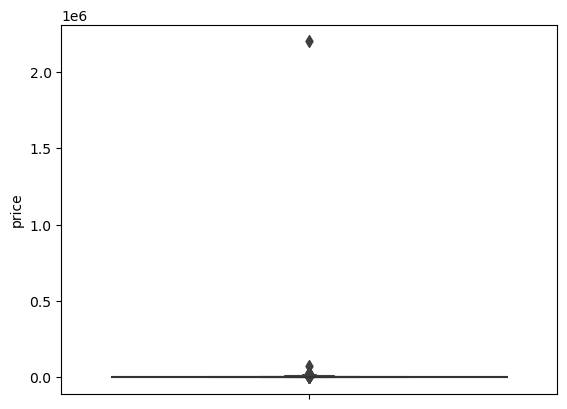

In [101]:
sns.boxenplot(data=data, y='price')

Based on the boxplot and the descriptive statistics, it is notable that this columns have some outliers that might hinder data analysis.
These values will be dealt with later when we examine if there are extreme values in the numerical columns.

#### 'bedrooms' column: 
The information regarding extra beedrooms (the number that may appear after the '+' for each row) convey a different information and should be sepparated into a new column 'extra_bedroom_spaces'. These extra beedroom spaces are not the same as conventional rooms, but might represent spaces where a person could sleep, such as a small room without space for furnite, a den, etc.

In [104]:
# Remove the characters "BD" from the 'bedrooms' columns
data['bedrooms'] = data['bedrooms'].str.replace('BD', '')

# Check if it worked
data.head()

,mls,address,price,bedrooms,bathrooms,parking,size,time_since_listed,broker,neighbourhood,city,region
0,C9350863,D - 32 Shank St,3500,2,3BA,2 Parking,1200-1399 sqft,15 minutes,LIVING REALTY INC.,king-west,Toronto,Downtown
1,C9347984,3713 - 35 Mercer St,2450,1,1BA,0 Parking,0-499 sqft,2 days,PROPERTY.CA INC.,king-west,Toronto,Downtown
2,C9350769,1508 - 8 Charlotte St,2450,1,1BA,0 Parking,500-599 sqft,15 minutes,LIVING REALTY INC.,king-west,Toronto,Downtown
3,C9352026,3204 - 327 King St W,2350,1,1BA,0 Parking,0-499 sqft,45 minutes,RE/MAX PLUS CITY TEAM INC.,king-west,Toronto,Downtown
4,C9351633,1013 - 1030 King St W,3600,2,2BA,1 Parking,600-699 sqft,45 minutes,RE/MAX EXCEL TITAN,king-west,Toronto,Downtown


In [105]:
# Check the values in the column 'bedrooms'
data['bedrooms'].value_counts(normalize=True)

bedrooms
2             0.280446
1             0.278338
1+1           0.197652
3             0.078880
2+1           0.067891
Not listed    0.047569
3+1           0.018064
4             0.011140
4+1           0.005419
5             0.003914
3+2           0.002258
5+1           0.002107
2+2           0.001505
5+2           0.001054
1+2           0.000903
4+2           0.000903
6+1           0.000602
3+3           0.000602
2+3           0.000301
6             0.000151
7+1           0.000151
8             0.000151
Name: proportion, dtype: float64

In [106]:
#Inspect row with number of bedrooms == 'Not listed'
data.loc[data['bedrooms'] == 'Not listed']

# As the units with number of bedrooms 'Not listed' account for only 5% of the dataset, will not add information to the analysis to be performed
# and will prevent to format the column's values as numeric, they will be removed.
data = data[data['bedrooms'] != 'Not listed']

#check if it worked
print(data['bedrooms'].value_counts())
print(data.loc[data['bedrooms'] == 'Not listed'])

bedrooms
2      1863
1      1849
1+1    1313
3       524
2+1     451
3+1     120
4        74
4+1      36
5        26
3+2      15
5+1      14
2+2      10
5+2       7
1+2       6
4+2       6
6+1       4
3+3       4
2+3       2
6         1
7+1       1
8         1
Name: count, dtype: int64
Empty DataFrame
Columns: [mls, address, price, bedrooms, bathrooms, parking, size, time_since_listed, broker, neighbourhood, city, region]
Index: []


In [107]:
# Separate information regarding the number of bedrooms and the number of extra bedrooms spaces

# Create lists to store the values
n_bedrooms = [] # List to store information regarding the number of bedrooms
n_extra_bedrooms = [] # List to store information regarding number of extra bedrooms spaces

# If there is a string with a '+' sign, use the number after the sign to create a value for a new column called 'extra_bedroom_spaces'.
# If there isn't a plus sign, the value for the new column should be 0.
# The value before the '+' sign is the number of bedrooms. In the case there is no '+' in the string, the value in the cell is the number of bedrooms.
for i in range(len(data)):
    bedrooms_spaces_list = data['bedrooms'].iloc[i].split('+')
    n_bedrooms.append(bedrooms_spaces_list[0])
    try:
        n_extra_bedrooms.append(bedrooms_spaces_list[1])
    except:
        n_extra_bedrooms.append(0)

# Add this information to the dataset
data['n_bedrooms'] = n_bedrooms
data['extra_bedroom_spaces'] = n_extra_bedrooms


# Change the dtype of the new columns to numeric
data['n_bedrooms'] = data['n_bedrooms'].astype(int)
data['extra_bedroom_spaces'] = data['extra_bedroom_spaces'].astype(int)

In [108]:
# Check if it worked
data[['bedrooms', 'n_bedrooms', 'extra_bedroom_spaces']].head(10)

,bedrooms,n_bedrooms,extra_bedroom_spaces
0,2,2,0
1,1,1,0
2,1,1,0
3,1,1,0
4,2,2,0
5,2,2,0
6,1+1,1,1
7,2,2,0
8,1,1,0
9,2,2,0


In [109]:
data[data['extra_bedroom_spaces'] > 1].head(10)

,mls,address,price,bedrooms,bathrooms,parking,size,time_since_listed,broker,neighbourhood,city,region,n_bedrooms,extra_bedroom_spaces
154,C9301863,204 - 705 King St W,3700,2+2,1BA,1 Parking,900-999 sqft,10 days,SAGE REAL ESTATE LIMITED,king-west,Toronto,Downtown,2,2
296,C9264711,903 - 71 Simcoe St,3600,1+2,2BA,1 Parking,1000-1199 sqft,25 days,SOHO CLASSIC REALTY LTD.,king-west,Toronto,Downtown,1,2
507,C9310094,603 - 650 Queens Quay W,2800,1+2,1BA,1 Parking,700-799 sqft,5 days,CENTURY 21 SMARTWAY REALTY INC.,harbourfront,Toronto,Downtown,1,2
937,C9268988,4203 - 65 St Mary St,3500,1+2,1BA,2 Parking,600-699 sqft,22 days,RE/MAX IMPERIAL REALTY INC.,bay-st-corridor,Toronto,Downtown,1,2
2085,C9309265,1002 - 151 Avenue Rd,8500,2+2,3BA,1 Parking,1400-1599 sqft,6 days,RE/MAX DASH REALTY,yorkville,Toronto,Downtown,2,2
2511,C9043163,307 - 373 Front St W,4500,2+2,2BA,1 Parking,900-999 sqft,60 days,CENTURY 21 LEADING EDGE REALTY INC.,cityplace,Toronto,Downtown,2,2
3031,C9310467,336 Hollywood Ave,4900,3+2,3BA,4 Parking,Not listed,5 days,FOREST HILL REAL ESTATE INC.,willowdale,Toronto,North York,3,2
3064,C9308839,290 Horsham Ave,4490,2+2,3BA,5 Parking,Not listed,7 days,CAPITAL NORTH REALTY CORPORATION,willowdale,Toronto,North York,2,2
3089,C9305209,19 Irvington Cres,6700,4+2,5BA,6 Parking,Not listed,9 days,FOREST HILL REAL ESTATE INC.,willowdale,Toronto,North York,4,2
3179,W9282317,39 Yorkview Dr,3895,2+2,2BA,4 Parking,700-1100 sqft,18 days,AGENTONDUTY INC.,willowdale,Toronto,North York,2,2


In [110]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6327 entries, 0 to 6673
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   mls                   6327 non-null   object
 1   address               6327 non-null   object
 2   price                 6327 non-null   int64 
 3   bedrooms              6327 non-null   object
 4   bathrooms             6327 non-null   object
 5   parking               6327 non-null   object
 6   size                  6327 non-null   object
 7   time_since_listed     6327 non-null   object
 8   broker                6327 non-null   object
 9   neighbourhood         6327 non-null   object
 10  city                  6327 non-null   object
 11  region                6327 non-null   object
 12  n_bedrooms            6327 non-null   int32 
 13  extra_bedroom_spaces  6327 non-null   int32 
dtypes: int32(2), int64(1), object(11)
memory usage: 692.0+ KB


In [111]:
# Remove 'bedrooms' columns as the information its information is now available in the columns 'n_beedroms' and 'extra_bedroom_spaces'
data = data.drop('bedrooms', axis=1)

# Rename the 'n_bedrooms' column to 'bedrooms'
data = data.rename(columns={'n_bedrooms': 'bedrooms'})

# Check if it worked
data.head()

,mls,address,price,bathrooms,parking,size,time_since_listed,broker,neighbourhood,city,region,bedrooms,extra_bedroom_spaces
0,C9350863,D - 32 Shank St,3500,3BA,2 Parking,1200-1399 sqft,15 minutes,LIVING REALTY INC.,king-west,Toronto,Downtown,2,0
1,C9347984,3713 - 35 Mercer St,2450,1BA,0 Parking,0-499 sqft,2 days,PROPERTY.CA INC.,king-west,Toronto,Downtown,1,0
2,C9350769,1508 - 8 Charlotte St,2450,1BA,0 Parking,500-599 sqft,15 minutes,LIVING REALTY INC.,king-west,Toronto,Downtown,1,0
3,C9352026,3204 - 327 King St W,2350,1BA,0 Parking,0-499 sqft,45 minutes,RE/MAX PLUS CITY TEAM INC.,king-west,Toronto,Downtown,1,0
4,C9351633,1013 - 1030 King St W,3600,2BA,1 Parking,600-699 sqft,45 minutes,RE/MAX EXCEL TITAN,king-west,Toronto,Downtown,2,0


#### 'bathrooms' column: 
The data must be numeric.

In [113]:
# Inspect column
data['bathrooms'].head()

0    3BA
1    1BA
2    1BA
3    1BA
4    2BA
Name: bathrooms, dtype: object

In [114]:
data['bathrooms'].value_counts()

bathrooms
1BA     3475
2BA     2348
3BA      356
4BA       80
5BA       41
6BA       13
8BA        5
0BA        3
7BA        3
11BA       1
10BA       1
9BA        1
Name: count, dtype: int64

In [115]:
# Remove 'BA' from 'bathrooms' column
data['bathrooms'] = data['bathrooms'].str.replace('BA', '')

# Change the dtype of the column to numeric
data['bathrooms'] = data['bathrooms'].astype(int)

#Check if it worked
data.head()

,mls,address,price,bathrooms,parking,size,time_since_listed,broker,neighbourhood,city,region,bedrooms,extra_bedroom_spaces
0,C9350863,D - 32 Shank St,3500,3,2 Parking,1200-1399 sqft,15 minutes,LIVING REALTY INC.,king-west,Toronto,Downtown,2,0
1,C9347984,3713 - 35 Mercer St,2450,1,0 Parking,0-499 sqft,2 days,PROPERTY.CA INC.,king-west,Toronto,Downtown,1,0
2,C9350769,1508 - 8 Charlotte St,2450,1,0 Parking,500-599 sqft,15 minutes,LIVING REALTY INC.,king-west,Toronto,Downtown,1,0
3,C9352026,3204 - 327 King St W,2350,1,0 Parking,0-499 sqft,45 minutes,RE/MAX PLUS CITY TEAM INC.,king-west,Toronto,Downtown,1,0
4,C9351633,1013 - 1030 King St W,3600,2,1 Parking,600-699 sqft,45 minutes,RE/MAX EXCEL TITAN,king-west,Toronto,Downtown,2,0


In [116]:
data['bathrooms'].value_counts()

bathrooms
1     3475
2     2348
3      356
4       80
5       41
6       13
8        5
0        3
7        3
11       1
10       1
9        1
Name: count, dtype: int64

In [117]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6327 entries, 0 to 6673
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   mls                   6327 non-null   object
 1   address               6327 non-null   object
 2   price                 6327 non-null   int64 
 3   bathrooms             6327 non-null   int32 
 4   parking               6327 non-null   object
 5   size                  6327 non-null   object
 6   time_since_listed     6327 non-null   object
 7   broker                6327 non-null   object
 8   neighbourhood         6327 non-null   object
 9   city                  6327 non-null   object
 10  region                6327 non-null   object
 11  bedrooms              6327 non-null   int32 
 12  extra_bedroom_spaces  6327 non-null   int32 
dtypes: int32(3), int64(1), object(9)
memory usage: 617.9+ KB


#### 'parking' column: 
The data must be numeric.

In [119]:
# Inspect column
data['parking'].head()

0    2 Parking
1    0 Parking
2    0 Parking
3    0 Parking
4    1 Parking
Name: parking, dtype: object

In [120]:
data['parking'].value_counts()

parking
1 Parking     3117
0 Parking     2702
2 Parking      311
3 Parking       66
4 Parking       54
6 Parking       34
5 Parking       19
8 Parking        8
7 Parking        6
10 Parking       4
12 Parking       3
9 Parking        2
18 Parking       1
Name: count, dtype: int64

In [121]:
# Remove ' Parking' from 'parking' column
data['parking'] = data['parking'].str.replace(' Parking', '')

# Change the dtype of the column to numeric
data['parking'] = data['parking'].astype(int)

#Check if it worked
data.head()

,mls,address,price,bathrooms,parking,size,time_since_listed,broker,neighbourhood,city,region,bedrooms,extra_bedroom_spaces
0,C9350863,D - 32 Shank St,3500,3,2,1200-1399 sqft,15 minutes,LIVING REALTY INC.,king-west,Toronto,Downtown,2,0
1,C9347984,3713 - 35 Mercer St,2450,1,0,0-499 sqft,2 days,PROPERTY.CA INC.,king-west,Toronto,Downtown,1,0
2,C9350769,1508 - 8 Charlotte St,2450,1,0,500-599 sqft,15 minutes,LIVING REALTY INC.,king-west,Toronto,Downtown,1,0
3,C9352026,3204 - 327 King St W,2350,1,0,0-499 sqft,45 minutes,RE/MAX PLUS CITY TEAM INC.,king-west,Toronto,Downtown,1,0
4,C9351633,1013 - 1030 King St W,3600,2,1,600-699 sqft,45 minutes,RE/MAX EXCEL TITAN,king-west,Toronto,Downtown,2,0


In [122]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6327 entries, 0 to 6673
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   mls                   6327 non-null   object
 1   address               6327 non-null   object
 2   price                 6327 non-null   int64 
 3   bathrooms             6327 non-null   int32 
 4   parking               6327 non-null   int32 
 5   size                  6327 non-null   object
 6   time_since_listed     6327 non-null   object
 7   broker                6327 non-null   object
 8   neighbourhood         6327 non-null   object
 9   city                  6327 non-null   object
 10  region                6327 non-null   object
 11  bedrooms              6327 non-null   int32 
 12  extra_bedroom_spaces  6327 non-null   int32 
dtypes: int32(4), int64(1), object(8)
memory usage: 593.2+ KB


#### 'size' column: 
the data must be numeric. The value must be a interger (i. e. 1500), not a range (i. e. 1500-1599).

In [124]:
# Inspect the columns
data['size'].head(10)

0    1200-1399 sqft
1        0-499 sqft
2      500-599 sqft
3        0-499 sqft
4      600-699 sqft
5    1400-1599 sqft
6      600-699 sqft
7      800-899 sqft
8      600-699 sqft
9      800-899 sqft
Name: size, dtype: object

In [125]:
data['size'].value_counts()

size
Not listed        1261
600-699 sqft      1098
500-599 sqft      1070
700-799 sqft       776
800-899 sqft       537
0-499 sqft         348
1000-1199 sqft     314
900-999 sqft       291
1200-1399 sqft     142
700-1100 sqft       99
1400-1599 sqft      82
1100-1500 sqft      62
1500-2000 sqft      56
1600-1799 sqft      34
1800-1999 sqft      31
2000-2500 sqft      22
2000-2249 sqft      19
2250-2499 sqft      14
3500-5000 sqft      13
3000-3500 sqft      11
2500-3000 sqft      10
2500-2749 sqft       7
3000-3249 sqft       7
2750-2999 sqft       4
3250-3499 sqft       2
5000 sqft            2
600 sqft             1
1732 sqft            1
638 sqft             1
950 sqft             1
1102 sqft            1
620 sqft             1
405 sqft             1
4750-4999 sqft       1
615 sqft             1
525 sqft             1
4000-4249 sqft       1
3500-3749 sqft       1
3750-3999 sqft       1
4022 sqft            1
1385 sqft            1
Name: count, dtype: int64

In [126]:
data['size'].value_counts(normalize=True) # Percent of the values in each category

size
Not listed        0.199305
600-699 sqft      0.173542
500-599 sqft      0.169116
700-799 sqft      0.122649
800-899 sqft      0.084874
0-499 sqft        0.055002
1000-1199 sqft    0.049629
900-999 sqft      0.045993
1200-1399 sqft    0.022443
700-1100 sqft     0.015647
1400-1599 sqft    0.012960
1100-1500 sqft    0.009799
1500-2000 sqft    0.008851
1600-1799 sqft    0.005374
1800-1999 sqft    0.004900
2000-2500 sqft    0.003477
2000-2249 sqft    0.003003
2250-2499 sqft    0.002213
3500-5000 sqft    0.002055
3000-3500 sqft    0.001739
2500-3000 sqft    0.001581
2500-2749 sqft    0.001106
3000-3249 sqft    0.001106
2750-2999 sqft    0.000632
3250-3499 sqft    0.000316
5000 sqft         0.000316
600 sqft          0.000158
1732 sqft         0.000158
638 sqft          0.000158
950 sqft          0.000158
1102 sqft         0.000158
620 sqft          0.000158
405 sqft          0.000158
4750-4999 sqft    0.000158
615 sqft          0.000158
525 sqft          0.000158
4000-4249 sqft    0.000

In [127]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6327 entries, 0 to 6673
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   mls                   6327 non-null   object
 1   address               6327 non-null   object
 2   price                 6327 non-null   int64 
 3   bathrooms             6327 non-null   int32 
 4   parking               6327 non-null   int32 
 5   size                  6327 non-null   object
 6   time_since_listed     6327 non-null   object
 7   broker                6327 non-null   object
 8   neighbourhood         6327 non-null   object
 9   city                  6327 non-null   object
 10  region                6327 non-null   object
 11  bedrooms              6327 non-null   int32 
 12  extra_bedroom_spaces  6327 non-null   int32 
dtypes: int32(4), int64(1), object(8)
memory usage: 593.2+ KB


In [128]:
# Remove ' sqft' from 'size' column
data['size'] = data['size'].str.replace(' sqft', '')

#Check if it worked
data['size'].head()

0    1200-1399
1        0-499
2      500-599
3        0-499
4      600-699
Name: size, dtype: object

The format of the values of this column encompasses a range that starts with a multiple of a hundred and ends with a multiple of a hundred plus 99 (i. e. 1500-1599) or a range that starts with 0 (for example, 0-499). Only the lowest value of the range will be retained, unless the lowest value is 0 (the only case of this being size equals 0-499). In order to replicate the logic performed in most cases, in case the range is 0-499 the value 400 will be kept.

In [130]:
# Create a lists to store the values
size = [] 

# If there is a string with a '-' sign, use the number before the sign if the value isn't 0. In the case it is 0, use the value 400. 
# If there isn't a '-', use the listed value.
for i in range(len(data)):
    if '-' in data['size'].iloc[i]:
        sqft_min = int(data['size'].iloc[i].split('-')[0])
        if sqft_min == 0:
            size.append(400)
        else:
            size.append(sqft_min)
    elif data['size'].iloc[i] == 'Not listed':
        size.append(data['size'].iloc[i])
    else:
        size.append(data['size'].iloc[i])

# Add this information to the dataset
data['size_sqft'] = size

# Check if it worked
data[['size', 'size_sqft']].head(10)

,size,size_sqft
0,1200-1399,1200
1,0-499,400
2,500-599,500
3,0-499,400
4,600-699,600
5,1400-1599,1400
6,600-699,600
7,800-899,800
8,600-699,600
9,800-899,800


In [131]:
data[data['size'] == 'Not listed'].head(10)

,mls,address,price,bathrooms,parking,size,time_since_listed,broker,neighbourhood,city,region,bedrooms,extra_bedroom_spaces,size_sqft
245,C9271823,24 Tecumseth St,4300,2,0,Not listed,19 days,SUTTON GROUP-ADMIRAL REALTY INC.,king-west,Toronto,Downtown,3,0,Not listed
246,C9270415,2ND FLR - 24 Tecumseth St,2000,1,0,Not listed,19 days,SUTTON GROUP-ADMIRAL REALTY INC.,king-west,Toronto,Downtown,1,0,Not listed
247,C9270414,MAIN&* - 24 Tecumseth St,2300,1,0,Not listed,19 days,SUTTON GROUP-ADMIRAL REALTY INC.,king-west,Toronto,Downtown,1,0,Not listed
256,C9270366,12 Joseph Salsberg Lane,5500,2,2,Not listed,20 days,HOMELIFE CLASSIC REALTY INC.,king-west,Toronto,Downtown,3,1,Not listed
362,C9247916,Main - 65 Stafford St,2600,1,0,Not listed,37 days,ROYAL LEPAGE CONNECT REALTY,king-west,Toronto,Downtown,1,0,Not listed
1197,C9303599,535 Yonge St,2650,1,0,Not listed,10 days,SUTTON GROUP-ADMIRAL REALTY INC.,church-st-corridor,Toronto,Downtown,1,0,Not listed
1243,C9284672,2 - 592 Church St,2799,1,1,Not listed,17 days,REAL ESTATE HOMEWARD,church-st-corridor,Toronto,Downtown,2,0,Not listed
1244,C9284133,Unit 2 - 125 Maitland St,3580,1,1,Not listed,17 days,FIRST CLASS REALTY INC.,church-st-corridor,Toronto,Downtown,3,0,Not listed
1245,C9284131,Main - 125 Maitland St,3550,1,0,Not listed,17 days,FIRST CLASS REALTY INC.,church-st-corridor,Toronto,Downtown,3,0,Not listed
1329,C9257999,Main fl - 99 Granby St,2400,1,0,Not listed,30 days,RE/MAX WEST REALTY INC.,church-st-corridor,Toronto,Downtown,1,0,Not listed


In [132]:
# Assing the value of 'size_sqft' to size and remove the extra column
data['size'] = size
data = data.drop('size_sqft', axis=1)

# Check if it worked
data.head()

,mls,address,price,bathrooms,parking,size,time_since_listed,broker,neighbourhood,city,region,bedrooms,extra_bedroom_spaces
0,C9350863,D - 32 Shank St,3500,3,2,1200,15 minutes,LIVING REALTY INC.,king-west,Toronto,Downtown,2,0
1,C9347984,3713 - 35 Mercer St,2450,1,0,400,2 days,PROPERTY.CA INC.,king-west,Toronto,Downtown,1,0
2,C9350769,1508 - 8 Charlotte St,2450,1,0,500,15 minutes,LIVING REALTY INC.,king-west,Toronto,Downtown,1,0
3,C9352026,3204 - 327 King St W,2350,1,0,400,45 minutes,RE/MAX PLUS CITY TEAM INC.,king-west,Toronto,Downtown,1,0
4,C9351633,1013 - 1030 King St W,3600,2,1,600,45 minutes,RE/MAX EXCEL TITAN,king-west,Toronto,Downtown,2,0


There are too many values 'Not listed' in the column 'size' (about 20% of the rows). If an analysis is to be performed using this column data, it might be necessary to deal with these rows. \
There are multiple options to deal with them, such as dropping the rows and value inputation. As imputing values for so many rows might influence statistical measures and the dataset has much more than the minimum required number of rows for analysis (1000) without them, we will continue by removing them.

In [134]:
# Remove rows without a value listed for size
data = data[data['size'] != 'Not listed']

# Convert 'size column to numeric'
data['size'] = data['size'].astype(int)

In [135]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5066 entries, 0 to 6641
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   mls                   5066 non-null   object
 1   address               5066 non-null   object
 2   price                 5066 non-null   int64 
 3   bathrooms             5066 non-null   int32 
 4   parking               5066 non-null   int32 
 5   size                  5066 non-null   int32 
 6   time_since_listed     5066 non-null   object
 7   broker                5066 non-null   object
 8   neighbourhood         5066 non-null   object
 9   city                  5066 non-null   object
 10  region                5066 non-null   object
 11  bedrooms              5066 non-null   int32 
 12  extra_bedroom_spaces  5066 non-null   int32 
dtypes: int32(5), int64(1), object(7)
memory usage: 455.1+ KB


In [136]:
data['size'].describe()

count    5066.000000
mean      752.110936
std       393.033406
min       400.000000
25%       500.000000
50%       700.000000
75%       800.000000
max      5000.000000
Name: size, dtype: float64

In [137]:
data.shape

(5066, 13)

#### 'time since listed' column: 
The data must be numeric.

In [139]:
# Inspect column
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5066 entries, 0 to 6641
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   mls                   5066 non-null   object
 1   address               5066 non-null   object
 2   price                 5066 non-null   int64 
 3   bathrooms             5066 non-null   int32 
 4   parking               5066 non-null   int32 
 5   size                  5066 non-null   int32 
 6   time_since_listed     5066 non-null   object
 7   broker                5066 non-null   object
 8   neighbourhood         5066 non-null   object
 9   city                  5066 non-null   object
 10  region                5066 non-null   object
 11  bedrooms              5066 non-null   int32 
 12  extra_bedroom_spaces  5066 non-null   int32 
dtypes: int32(5), int64(1), object(7)
memory usage: 455.1+ KB


In [140]:
data['time_since_listed'].unique()

array(['15 minutes', '2 days', '45 minutes', '1 day', '6 days', '33 days',
       '20 days', '11 days', '3 days', '4 days', '19 days', '5 days',
       '7 days', '8 days', '9 days', '10 days', '12 days', '13 days',
       '14 days', '15 days', '16 days', '17 days', '18 days', '21 days',
       '22 days', '23 days', '24 days', '25 days', '26 days', '27 days',
       '28 days', '29 days', '30 days', '31 days', '32 days', '34 days',
       '35 days', '36 days', '37 days', '38 days', '39 days', '40 days',
       '41 days', '42 days', '43 days', '44 days', '45 days', '46 days',
       '48 days', '49 days', '51 days', '52 days', '53 days', '56 days',
       '58 days', '60 days', '61 days', '62 days', '64 days', '66 days',
       '67 days', '68 days', '69 days', '70 days', '72 days', '73 days',
       '74 days', '76 days', '81 days', '87 days', '88 days', '90 days',
       '92 days', '93 days', '95 days', '126 days', '131 days',
       '146 days', '19 minutes', '114 days', '47 days', '50 days

In [141]:
print(data['time_since_listed'].value_counts().to_string()) # Added to_string() to display all rows

time_since_listed
5 days        241
6 days        233
9 days        211
3 days        193
4 days        192
2 days        180
10 days       179
11 days       171
12 days       167
1 day         128
19 days       121
20 days       110
26 days       106
17 days       105
16 days       100
31 days        97
18 days        97
27 days        90
23 days        89
34 days        82
8 days         79
25 days        79
24 days        78
7 days         76
37 days        74
32 days        70
30 days        69
40 days        66
33 days        66
38 days        58
14 days        54
13 days        53
45 days        53
39 days        52
15 days        51
44 days        40
22 days        38
55 days        35
48 days        34
47 days        33
29 days        33
52 days        28
21 days        28
58 days        27
46 days        27
35 days        27
28 days        26
53 days        26
54 days        25
73 days        23
62 days        23
36 days        23
43 days        22
69 days        21
41 days   

In [142]:
data[data['time_since_listed'].str.endswith('minutes')]

,mls,address,price,bathrooms,parking,size,time_since_listed,broker,neighbourhood,city,region,bedrooms,extra_bedroom_spaces
0,C9350863,D - 32 Shank St,3500,3,2,1200,15 minutes,LIVING REALTY INC.,king-west,Toronto,Downtown,2,0
2,C9350769,1508 - 8 Charlotte St,2450,1,0,500,15 minutes,LIVING REALTY INC.,king-west,Toronto,Downtown,1,0
3,C9352026,3204 - 327 King St W,2350,1,0,400,45 minutes,RE/MAX PLUS CITY TEAM INC.,king-west,Toronto,Downtown,1,0
4,C9351633,1013 - 1030 King St W,3600,2,1,600,45 minutes,RE/MAX EXCEL TITAN,king-west,Toronto,Downtown,2,0
5,C9351614,4802 - 300 Front St W,5700,3,2,1400,45 minutes,ROYAL LEPAGE TERREQUITY PLATINUM REALTY,king-west,Toronto,Downtown,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5779,C9351776,1908 - 75 Wynford Heights Cres,4500,2,2,1400,44 minutes,ROYAL LEPAGE CONNECT REALTY,flemingdon-park,Toronto,East York,2,1
5780,C9351461,305 - 797 Don Mills Rd,3500,2,1,1000,44 minutes,RE/MAX EXCEL TITAN,flemingdon-park,Toronto,East York,2,1
5935,E9350682,Main - 169 Bellefair Ave,3295,1,1,700,17 minutes,ROYAL LEPAGE SIGNATURE REALTY,the-beach,Toronto,East End,2,0
6026,E9352075,209 - 45 Baseball Pl,3000,1,1,600,48 minutes,THE CONDO STORE REALTY INC.,riverside,Toronto,East End,2,0


In [143]:
data[data['time_since_listed'].str.endswith('hours')]

,mls,address,price,bathrooms,parking,size,time_since_listed,broker,neighbourhood,city,region,bedrooms,extra_bedroom_spaces
4462,H4206217,1404 - 710 HUMBERWOOD Boulevard,3200,0,1,950,17 hours,"Keller Williams Edge Realty, Brokerage",west-humber-clairville,Toronto,Etobicoke,2,0


In [144]:
# Days will be use as the metric for this column. The values od the rows which cotains minutes will be changed to 0
data.loc[data['time_since_listed'].str.endswith('minutes'), 'time_since_listed'] = '0 days'
data.loc[data['time_since_listed'].str.endswith('hour'), 'time_since_listed'] = '0 days'
data.loc[data['time_since_listed'].str.endswith('hours'), 'time_since_listed'] = '0 days'

In [145]:
# Check if it worked
data.loc[data['time_since_listed'] == '0 days', 'time_since_listed']

0       0 days
2       0 days
3       0 days
4       0 days
5       0 days
         ...  
5779    0 days
5780    0 days
5935    0 days
6026    0 days
6188    0 days
Name: time_since_listed, Length: 141, dtype: object

In [146]:
# Remove ' days' and ' day' from time_since_liste column
data['time_since_listed'] = data['time_since_listed'].str.replace(' days', '')
data['time_since_listed'] = data['time_since_listed'].str.replace(' day', '')

# Convert the column to numeric
data['time_since_listed'] = data['time_since_listed'].astype(int)

#Check if it worked
data.head()

,mls,address,price,bathrooms,parking,size,time_since_listed,broker,neighbourhood,city,region,bedrooms,extra_bedroom_spaces
0,C9350863,D - 32 Shank St,3500,3,2,1200,0,LIVING REALTY INC.,king-west,Toronto,Downtown,2,0
1,C9347984,3713 - 35 Mercer St,2450,1,0,400,2,PROPERTY.CA INC.,king-west,Toronto,Downtown,1,0
2,C9350769,1508 - 8 Charlotte St,2450,1,0,500,0,LIVING REALTY INC.,king-west,Toronto,Downtown,1,0
3,C9352026,3204 - 327 King St W,2350,1,0,400,0,RE/MAX PLUS CITY TEAM INC.,king-west,Toronto,Downtown,1,0
4,C9351633,1013 - 1030 King St W,3600,2,1,600,0,RE/MAX EXCEL TITAN,king-west,Toronto,Downtown,2,0


In [147]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5066 entries, 0 to 6641
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   mls                   5066 non-null   object
 1   address               5066 non-null   object
 2   price                 5066 non-null   int64 
 3   bathrooms             5066 non-null   int32 
 4   parking               5066 non-null   int32 
 5   size                  5066 non-null   int32 
 6   time_since_listed     5066 non-null   int32 
 7   broker                5066 non-null   object
 8   neighbourhood         5066 non-null   object
 9   city                  5066 non-null   object
 10  region                5066 non-null   object
 11  bedrooms              5066 non-null   int32 
 12  extra_bedroom_spaces  5066 non-null   int32 
dtypes: int32(6), int64(1), object(6)
memory usage: 435.4+ KB


In [148]:
data['time_since_listed'].describe()

count    5066.000000
mean       25.020529
std        26.931099
min         0.000000
25%         6.000000
50%        17.000000
75%        34.000000
max       308.000000
Name: time_since_listed, dtype: float64

In [149]:
# Lastly, change the name of the column from 'time_since_listed' to 'days_since_listed'
data = data.rename(columns={'time_since_listed': 'days_since_listed'})
data.columns

Index(['mls', 'address', 'price', 'bathrooms', 'parking', 'size',
       'days_since_listed', 'broker', 'neighbourhood', 'city', 'region',
       'bedrooms', 'extra_bedroom_spaces'],
      dtype='object')

#### 'neighbourhood' column: 
The name of the neighbourhood is not formated correctly.

In [151]:
# The values for the neighbourhood' column follow a pattern described earlier in this notebook. The only cleaning needed is to change the format of the 
# values

# Spaces in the actual neighbourhood names are separated by '-' in the dataset. Initials must be capitalized
data['neighbourhood'] = data['neighbourhood'].str.replace('-', ' ').apply(str.title) # Replace '-' for ' ' in the values of the column and capitalize initials

#Check if it worked
data['neighbourhood'].unique()

array(['King West', 'Harbourfront', 'Bay St Corridor',
       'Church St Corridor', 'Yonge And Bloor', 'Queen West',
       'St Lawrence', 'Yorkville', 'Financial District', 'Cityplace',
       'Cabbagetown', 'Fort York', 'Regent Park', 'Grange Park',
       'Willowdale', 'Bayview Village', 'Newtonbrook', 'Downsview',
       'Henry Farm', 'Wilson Heights', 'St Andrew York Mills',
       'Banbury Don Mills', 'The Peanut', 'Amesbury',
       'University Heights', 'Lansing', 'Parkwoods', 'Yorkdale', 'Mimico',
       'Islington City Centre West', 'West Humber Clairville',
       'Stonegate Queensway', 'Long Branch', 'Scarborough Village',
       'Edenbridge Humber Valley', 'New Toronto', 'Richview', 'Alderwood',
       'Humber Heights', 'Eringate Centennial West Deane',
       'Kingsview Village', 'Markland Wood', 'Yonge And Eglinton',
       'Humewood Cedarvale', 'Mount Pleasant', 'Carleton Village',
       'Deer Park', 'Forest Hill', 'Davisville Village', 'Corso Italia',
       'Lytton P

#### 'city' and 'region' columns: 
No cleaning required.

#### **3. Check for null values**
It is also necessary to check for null values. In the case of this dataset, null values are coded as 'Not listed'.

In [154]:
# Check for the frequency of the value 'Not listed' in each column

for i in data.columns:
    try:
        print(f"{i}: {data[i].value_counts()['Not listed']}")
    except:
        print(f"{i}: 0")

mls: 0
address: 0
price: 0
bathrooms: 0
parking: 0
size: 0
days_since_listed: 0
broker: 0
neighbourhood: 0
city: 0
region: 0
bedrooms: 0
extra_bedroom_spaces: 0


#### Check for strange values
It is also necessary to validate numerical values and deal with anomalies.

In [156]:
# Check descripptive statitics
pd.options.display.float_format = '{:.2f}'.format # Change display to avoid scientific notation
data.describe()

,price,bathrooms,parking,size,days_since_listed,bedrooms,extra_bedroom_spaces
count,5066.00,5066.00,5066.00,5066.00,5066.00,5066.00,5066.00
mean,3276.84,1.56,0.65,752.11,25.02,1.57,0.36
std,1632.15,0.70,0.70,393.03,26.93,0.70,0.49
min,1199.00,0.00,0.00,400.00,0.00,1.00,0.00
25%,2500.00,1.00,0.00,500.00,6.00,1.00,0.00
50%,2850.00,1.00,1.00,700.00,17.00,1.00,0.00
75%,3500.00,2.00,1.00,800.00,34.00,2.00,1.00
max,30000.00,11.00,12.00,5000.00,308.00,8.00,3.00


In [157]:
# Check correlations
data.corr(numeric_only=True)

,price,bathrooms,parking,size,days_since_listed,bedrooms,extra_bedroom_spaces
price,1.00,0.64,0.43,0.79,0.20,0.54,0.04
bathrooms,0.64,1.00,0.48,0.74,0.08,0.72,0.01
parking,0.43,0.48,1.00,0.59,0.05,0.46,0.07
size,0.79,0.74,0.59,1.00,0.13,0.69,0.05
days_since_listed,0.20,0.08,0.05,0.13,1.00,0.07,0.00
bedrooms,0.54,0.72,0.46,0.69,0.07,1.00,-0.21
extra_bedroom_spaces,0.04,0.01,0.07,0.05,0.00,-0.21,1.00


Some columns comport an extreme range of values. For example, the column 'price' has min value of 1199.00 and max value of 30000.00. If those values are not removed from the dataset, they will have a disproportional impact on summaries of the data (i. e. mean, correlations) and might hinder data analysis and insight.
By looking at the mean and standard deviation of the columns, using a method of removing outliers based on the z-score does not seem the best option. 
Others methods such as using a filter based on interquantile range or percentile should be explored.

In [159]:
# Create a list of numeric columns
numeric_columns = ['price', 'size', 'bathrooms', 'parking', 'days_since_listed', 'bedrooms', 'extra_bedroom_spaces']

# Check interquantile range (one of the ways to deal with outliers is based on distance regarding thisi metric)
IQR = data[numeric_columns].quantile(0.75) - data[numeric_columns].quantile(0.25)
IQR

price                  1000.00
size                    300.00
bathrooms                 1.00
parking                   1.00
days_since_listed        28.00
bedrooms                  1.00
extra_bedroom_spaces      1.00
dtype: float64

By analysing the IQR, it does not seem that the interquantile range would be a good method to deal with outliers in this dataset either. It would remove many units within a normal price range and with a reasonable number of bathromms/parking/bedrooms.

In [161]:
# Examine the 99th and 1st percentile
print(data[numeric_columns].quantile(0.99))
print(data[numeric_columns].quantile(0.01))

price                  10000.00
size                    2500.00
bathrooms                  4.00
parking                    3.00
days_since_listed        122.00
bedrooms                   4.00
extra_bedroom_spaces       1.00
Name: 0.99, dtype: float64
price                  1900.00
size                    400.00
bathrooms                 1.00
parking                   0.00
days_since_listed         0.00
bedrooms                  1.00
extra_bedroom_spaces      0.00
Name: 0.01, dtype: float64


In [162]:
# Examine number of observations for unique values
for col in numeric_columns:
    print(data[col].value_counts())

price
2500     275
2400     245
2600     224
2700     182
2800     180
        ... 
3583       1
6725       1
20100      1
7995       1
5195       1
Name: count, Length: 420, dtype: int64
size
600     1099
500     1070
700      875
800      537
400      348
1000     314
900      291
1200     142
1400      82
1100      62
1500      56
2000      41
1600      34
1800      31
3000      18
2500      17
2250      14
3500      14
2750       4
5000       2
3250       2
950        1
638        1
620        1
1732       1
1102       1
615        1
4750       1
405        1
3750       1
4022       1
4000       1
525        1
1385       1
Name: count, dtype: int64
bathrooms
1     2652
2     2088
3      263
4       35
5       18
6        4
0        3
8        2
11       1
Name: count, dtype: int64
parking
1     2714
0     2117
2      183
3       21
6       10
4        9
5        8
7        2
8        1
12       1
Name: count, dtype: int64
days_since_listed
5      241
6      233
9      211
3      19

By contextualizing the numbers with the real state market and observing the number of rows that contain each value, it seems reasonable to remove the data points that fall beyond the 99th percentile for the columns 'price', 'size' and 'days_since_listed', and the ones that fall bellow the 1st percentile for bathrooms (which are properties with 0 bathrooms). This would remove only rows with extreme values that do not represent the data well, which could impact the quality of summary measures negatively. \
Moreover, for the columns 'bathrooms', 'parking', 'bedrooms', 'extra_bedroom_spaces' it seems reasonable to handle them as ordered categorical variables. This would prevent the incusion of values with a very small number of observations, which could also hinder data analysis. For example, the distribution of values in the columns 'bedrooms' is the following:

In [164]:
data['bedrooms'].value_counts()

bedrooms
1    2699
2    1909
3     397
4      48
5      11
8       1
6       1
Name: count, dtype: int64

It seems reasonable to separate the values into four categories: 1 bedroom, 2 bedrooms, 3 bedrooms, 4+ bedrooms. The same logic is applicable for the 'bathrooms', 'parking', 'bedrooms', 'extra_bedroom_spaces' in order to maintain a sizeable number of observations per category in them.

In [166]:
# Define list of columns that will have and upper or lower limit
top_limit_cols = ['price', 'size', 'days_since_listed']
lower_limit_cols = ['bathrooms']

# Create a subset of the data by removing outliers based on the lists created and their quantiles
data_subset = data.copy()

for col in top_limit_cols:
    data_subset = data_subset[(data[col] <= data_subset[col].quantile(0.99))]

for col in lower_limit_cols:
    data_subset = data_subset[(data_subset[col] >= data_subset[col].quantile(0.01))]

C:\Users\Diogo\AppData\Local\Temp\ipykernel_1192\1186997005.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_subset = data_subset[(data[col] <= data_subset[col].quantile(0.99))]
C:\Users\Diogo\AppData\Local\Temp\ipykernel_1192\1186997005.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_subset = data_subset[(data[col] <= data_subset[col].quantile(0.99))]


In [167]:
# Check if it worked
data_subset.describe()

,price,bathrooms,parking,size,days_since_listed,bedrooms,extra_bedroom_spaces
count,4922.00,4922.00,4922.00,4922.00,4922.00,4922.00,4922.00
mean,3114.32,1.52,0.62,713.88,23.25,1.54,0.36
std,984.00,0.60,0.61,269.25,21.60,0.66,0.49
min,1199.00,1.00,0.00,400.00,0.00,1.00,0.00
25%,2500.00,1.00,0.00,500.00,6.00,1.00,0.00
50%,2800.00,1.00,1.00,600.00,17.00,1.00,0.00
75%,3448.75,2.00,1.00,800.00,33.00,2.00,1.00
max,10000.00,5.00,8.00,2000.00,114.00,5.00,3.00


In [168]:
# Trasform columns 'bedrooms' to categorical
bedrooms_categorical = pd.cut(x=data_subset['bedrooms'], bins=[0,1,2,3,data['bedrooms'].max()], labels=['1', '2', '3', '4+'], ordered=True)

In [169]:
# Check if it worked
print(bedrooms_categorical[:5])
print(data['bedrooms'].iloc[:5])

# inspect if the count of each value in 'bedrooms_categorical' is as expected considering the values of the 'bedroom' column
print(Counter(bedrooms_categorical))
print(data_subset['bedrooms'].value_counts())

0    2
1    1
2    1
3    1
4    2
Name: bedrooms, dtype: category
Categories (4, object): ['1' < '2' < '3' < '4+']
0    2
1    1
2    1
3    1
4    2
Name: bedrooms, dtype: int32
Counter({'1': 2674, '2': 1859, '3': 356, '4+': 33})
bedrooms
1    2674
2    1859
3     356
4      30
5       3
Name: count, dtype: int64


In [170]:
# Add bedrooms_categorical as the new value for the 'bedrooms' column
data_subset['bedrooms'] = bedrooms_categorical

data_subset.head()

,mls,address,price,bathrooms,parking,size,days_since_listed,broker,neighbourhood,city,region,bedrooms,extra_bedroom_spaces
0,C9350863,D - 32 Shank St,3500,3,2,1200,0,LIVING REALTY INC.,King West,Toronto,Downtown,2,0
1,C9347984,3713 - 35 Mercer St,2450,1,0,400,2,PROPERTY.CA INC.,King West,Toronto,Downtown,1,0
2,C9350769,1508 - 8 Charlotte St,2450,1,0,500,0,LIVING REALTY INC.,King West,Toronto,Downtown,1,0
3,C9352026,3204 - 327 King St W,2350,1,0,400,0,RE/MAX PLUS CITY TEAM INC.,King West,Toronto,Downtown,1,0
4,C9351633,1013 - 1030 King St W,3600,2,1,600,0,RE/MAX EXCEL TITAN,King West,Toronto,Downtown,2,0


In [171]:
# Transform 'extra_bedroom_spaces' to categorical

# Check column original values
data_subset['extra_bedroom_spaces'].value_counts()

extra_bedroom_spaces
0    3166
1    1743
2      12
3       1
Name: count, dtype: int64

In [172]:
# Create the series extra_bedroom_spaces_categorical with the categorical values for the variable
extra_bedroom_spaces_categorical = pd.cut(x=data_subset['extra_bedroom_spaces'], bins=[data_subset['extra_bedroom_spaces'].min() - 1,0,1, data_subset['extra_bedroom_spaces'].max()], labels=['0', '1', '2+'], ordered=True)

#Check if it worked
print(Counter(extra_bedroom_spaces_categorical))
print(data_subset['extra_bedroom_spaces'].value_counts())

Counter({'0': 3166, '1': 1743, '2+': 13})
extra_bedroom_spaces
0    3166
1    1743
2      12
3       1
Name: count, dtype: int64


In [173]:
# Add extra_bedroom_spaces_categorical as the new value for the 'extra_bedroom_spaces' column
data_subset['extra_bedroom_spaces'] = extra_bedroom_spaces_categorical

In [174]:
# Transform 'bathrooms' to categorical

# Check column original values
data_subset['bathrooms'].value_counts()

bathrooms
1    2624
2    2068
3     210
4      16
5       4
Name: count, dtype: int64

In [175]:
# Create the series bathrooms_categorical with the categorical values for the variable
bathrooms_categorical = pd.cut(x=data_subset['bathrooms'], bins=[0,1,2,3, data_subset['bathrooms'].max() + 1], labels=['1', '2', '3', '4+'], ordered=True)

#Check if it worked
print(Counter(bathrooms_categorical))
print(data_subset['bathrooms'].value_counts())

Counter({'1': 2624, '2': 2068, '3': 210, '4+': 20})
bathrooms
1    2624
2    2068
3     210
4      16
5       4
Name: count, dtype: int64


In [176]:
# Add bathrooms_categorical as the new value for the 'bathrooms' column
data_subset['bathrooms'] = bathrooms_categorical

In [177]:
# Transform 'parking' to categorical

# Check column original values
data_subset['parking'].value_counts()

parking
1    2662
0    2091
2     140
3      16
5       6
4       4
6       2
8       1
Name: count, dtype: int64

In [178]:
# Create the series parking_categorical with the categorical values for the variable
parking_categorical = pd.cut(x=data_subset['parking'], bins=[data_subset['parking'].min() - 1,0,1,2, data_subset['parking'].max() + 1], labels=['0', '1', '2', '3+'], ordered=True)

#Check if it worked
print(Counter(parking_categorical))
print(data_subset['parking'].value_counts())

Counter({'1': 2662, '0': 2091, '2': 140, '3+': 29})
parking
1    2662
0    2091
2     140
3      16
5       6
4       4
6       2
8       1
Name: count, dtype: int64


In [179]:
# Add parking_categorical as the new value for the 'parking' column
data_subset['parking'] = bathrooms_categorical

In [180]:
data_subset.corr(numeric_only=True)

,price,size,days_since_listed
price,1.00,0.76,0.13
size,0.76,1.00,0.08
days_since_listed,0.13,0.08,1.00


In [181]:
# Check the values left per city

data_subset['city'].value_counts()

city
Toronto      4921
Vancouver       1
Name: count, dtype: int64

Even though our initial idea was to analyze the cities of Vancouver and Toronto, it is a better idea do stick onl to the city of Toronto. That is because, of all the 4963 rows retained after data cleaning, only one of them corresponds to the city of Vancouver.

In [183]:
toronto_rentals = data_subset[data_subset['city'] == 'Toronto']

## Data Analysis
Now that the data has been gathered and cleaned, it is time to proceed with the data analysis. The analysis will aim to understand how some of the variables in the dataset may affect the price of rent.

In [185]:
# Inspect toronto_rentals
toronto_rentals.head()

,mls,address,price,bathrooms,parking,size,days_since_listed,broker,neighbourhood,city,region,bedrooms,extra_bedroom_spaces
0,C9350863,D - 32 Shank St,3500,3,3,1200,0,LIVING REALTY INC.,King West,Toronto,Downtown,2,0
1,C9347984,3713 - 35 Mercer St,2450,1,1,400,2,PROPERTY.CA INC.,King West,Toronto,Downtown,1,0
2,C9350769,1508 - 8 Charlotte St,2450,1,1,500,0,LIVING REALTY INC.,King West,Toronto,Downtown,1,0
3,C9352026,3204 - 327 King St W,2350,1,1,400,0,RE/MAX PLUS CITY TEAM INC.,King West,Toronto,Downtown,1,0
4,C9351633,1013 - 1030 King St W,3600,2,2,600,0,RE/MAX EXCEL TITAN,King West,Toronto,Downtown,2,0


### Relationships between price and other continuous numerical variables

C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


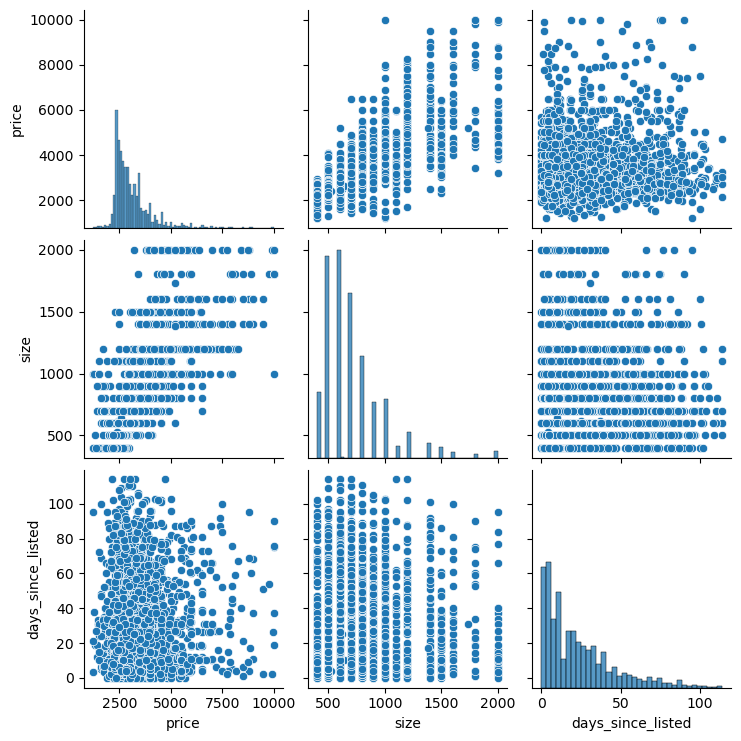

In [187]:
sns.pairplot(toronto_rentals)

There is no apparent meaningful relationship between price and days_since list. However, the relationship between 'price' and 'size' seems worth exploring further.

C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


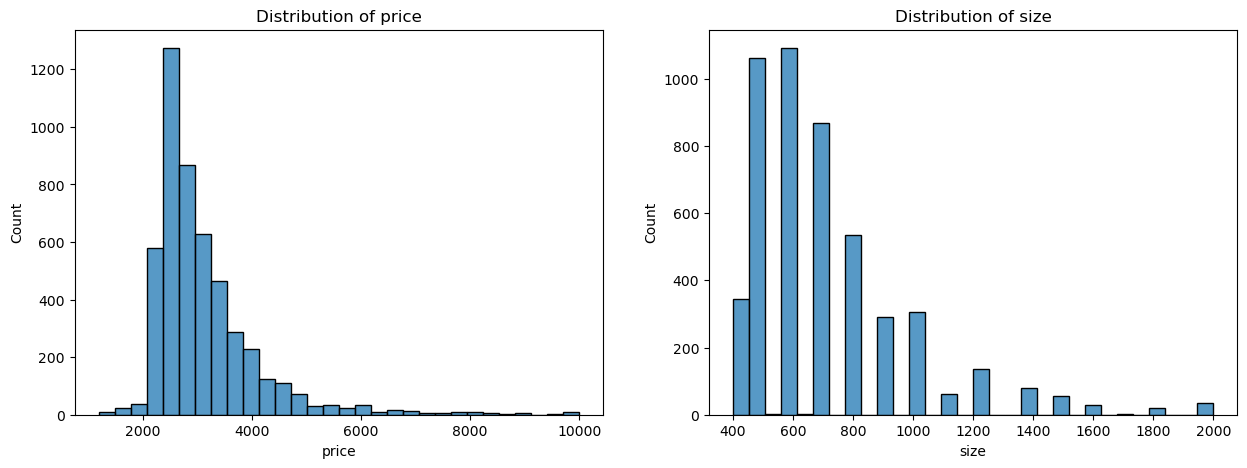

In [189]:
# Inspect the distribution of 'price' and 'size' variables
fig, ((ax0, ax1)) = plt.subplots(1, 2, figsize=(15, 5))
sns.histplot(data=toronto_rentals, x='price', bins=30, ax=ax0).set(title='Distribution of price');
sns.histplot(data=toronto_rentals, x='size', bins=30, ax=ax1).set(title='Distribution of size');

Both 'price' and 'size' seem to be right skewed.

Text(0.5, 0, 'Size')

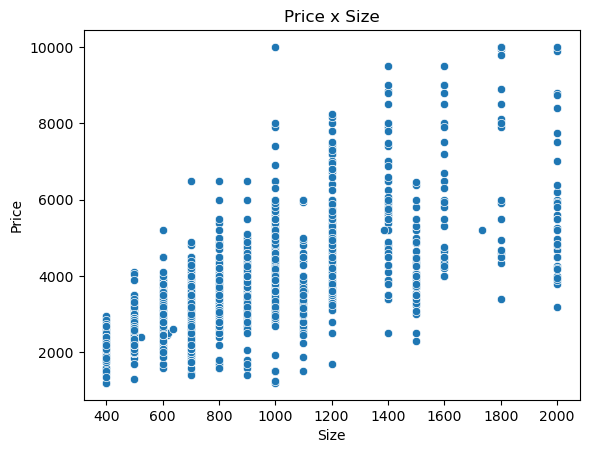

In [191]:
# Investigate their relationship

# Create a scatter plot
plt.figsize=(5, 5)
sns.scatterplot(data=toronto_rentals, x='size', y='price')
plt.title('Price x Size')
plt.ylabel('Price')
plt.xlabel('Size')

<Axes: >

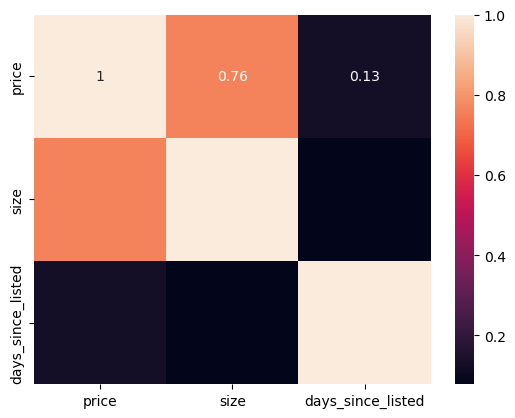

In [192]:
# Create correation heatmap
sns.heatmap(toronto_rentals.corr(numeric_only=True), annot=True)

The two variables seem to have a linear relationship and a linear regression could be informative.

In [194]:
import statsmodels.formula.api as smf # To perform linear regression

# Fit the linear regression model
model = smf.ols(formula='price ~ size', data=toronto_rentals).fit()
 
# Print model summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.581
Model:                            OLS   Adj. R-squared:                  0.581
Method:                 Least Squares   F-statistic:                     6818.
Date:                Fri, 11 Oct 2024   Prob (F-statistic):               0.00
Time:                        11:17:29   Log-Likelihood:                -38756.
No. Observations:                4921   AIC:                         7.752e+04
Df Residuals:                    4919   BIC:                         7.753e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1121.9134     25.781     43.518      0.0

The model estimates that the price of a property can be calculated by the formula: 1121.91 + 2.79 * (size of the unit in sqft). This model accounts for approximately 58% of the variation of the variable price, which is reasonable considering its simplicity..

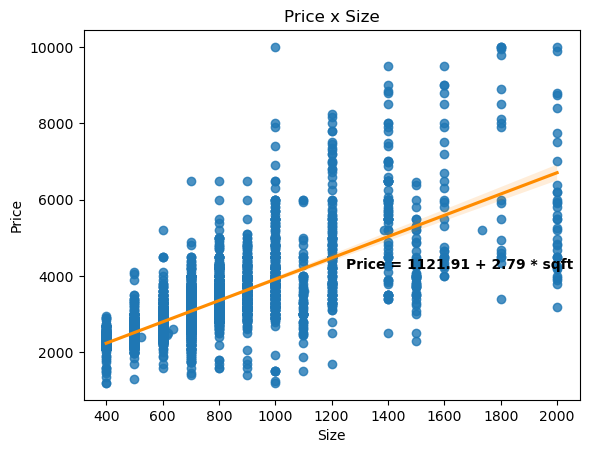

In [196]:
# Plot the data with the regression line
plt.figsize=(5, 5)
sns.regplot(data=toronto_rentals, x='size', y='price', line_kws={"color": "darkorange"})
plt.title('Price x Size')
plt.ylabel('Price')
plt.xlabel('Size')
plt.savefig('Price per size.png')
plt.annotate('Price = 1121.91 + 2.79 * sqft', xy=(1250, 4200), fontsize=10, weight='bold')
plt.savefig('Price per size.png')

#### Price and number of bedrooms

C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1057: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_data = data.groupby(


Text(0.5, 1.0, 'Price distribution per number of bedrooms')

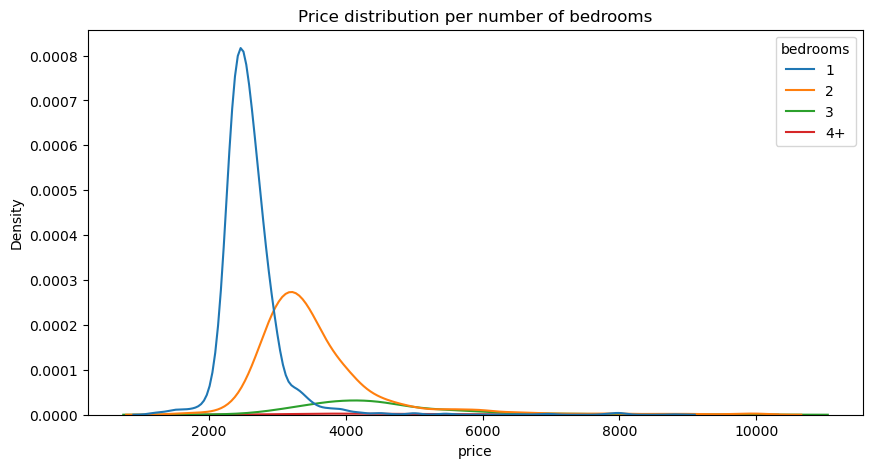

In [198]:
# Distribution of price per number of bedrooms

plt.figure(figsize=(10, 5))
sns.kdeplot(data=toronto_rentals, x='price', hue='bedrooms')
plt.title('Price distribution per number of bedrooms')

C:\Users\Diogo\AppData\Local\Temp\ipykernel_1192\3210343822.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_price_per_bedrooms_and_region = toronto_rentals.groupby('bedrooms', as_index=False)[['price']].mean().round(0)
C:\ProgramData\anaconda3\Lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


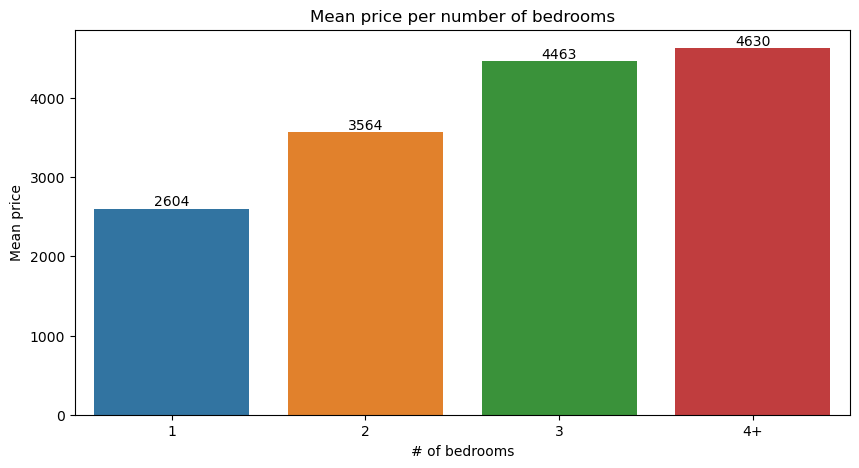

In [199]:
# Average price per number of bedrooms

mean_price_per_bedrooms_and_region = toronto_rentals.groupby('bedrooms', as_index=False)[['price']].mean().round(0)
plt.figure(figsize=(10,5))
ax = sns.barplot(data=mean_price_per_bedrooms_and_region, x='bedrooms', y='price')
ax.bar_label(ax.containers[0])
plt.ylabel('Mean price')
plt.xlabel('# of bedrooms')
plt.title('Mean price per number of bedrooms')
plt.savefig('Mean price per number of bedrooms.png')

C:\Users\Diogo\AppData\Local\Temp\ipykernel_1192\3853393155.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_price_per_bedrooms_and_region = toronto_rentals.groupby(['region', 'bedrooms'], as_index=False)[['price']].mean().round(0)


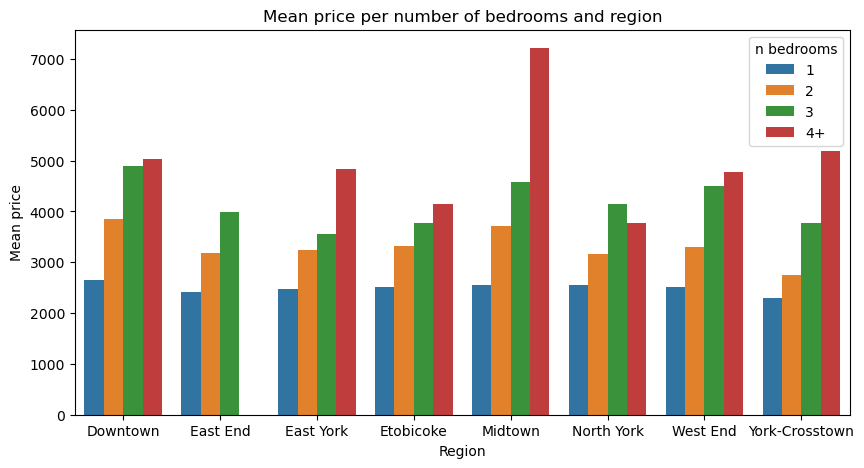

In [200]:
# Average price per number of bedrooms in each region of the city

mean_price_per_bedrooms_and_region = toronto_rentals.groupby(['region', 'bedrooms'], as_index=False)[['price']].mean().round(0)
plt.figure(figsize=(10,5))
ax = sns.barplot(data=mean_price_per_bedrooms_and_region, x='region', y='price', hue='bedrooms')
plt.ylabel('Mean price')
plt.xlabel('Region')
plt.title('Mean price per number of bedrooms and region')
plt.legend(title='n bedrooms')
plt.savefig('Mean price per number of bedrooms and region.png')

In all regions, excep for North York, more bedrooms seems ro leads to higher prices. \
When we compare the mean price per number of bedrooms in different regions we notice an interesting difference. The mean price per number per pproperties with 3 and 4+ bedrooms is lower in some of the regions of the city when compared to others. For instance, the price for 3 bedroom units are lower in East York, Etobicoke and York-Crosstown seems atractive when cocmpared to the other regions, and the price for 4+ properties are better in Nort York and Etobicoke and particularly high in Midtown.

### Offer of units based on number of bedrooms in eac region

C:\Users\Diogo\AppData\Local\Temp\ipykernel_1192\3870129654.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  n_bedrooms_and_region = toronto_rentals.groupby(['region', 'bedrooms']).size().unstack(0)


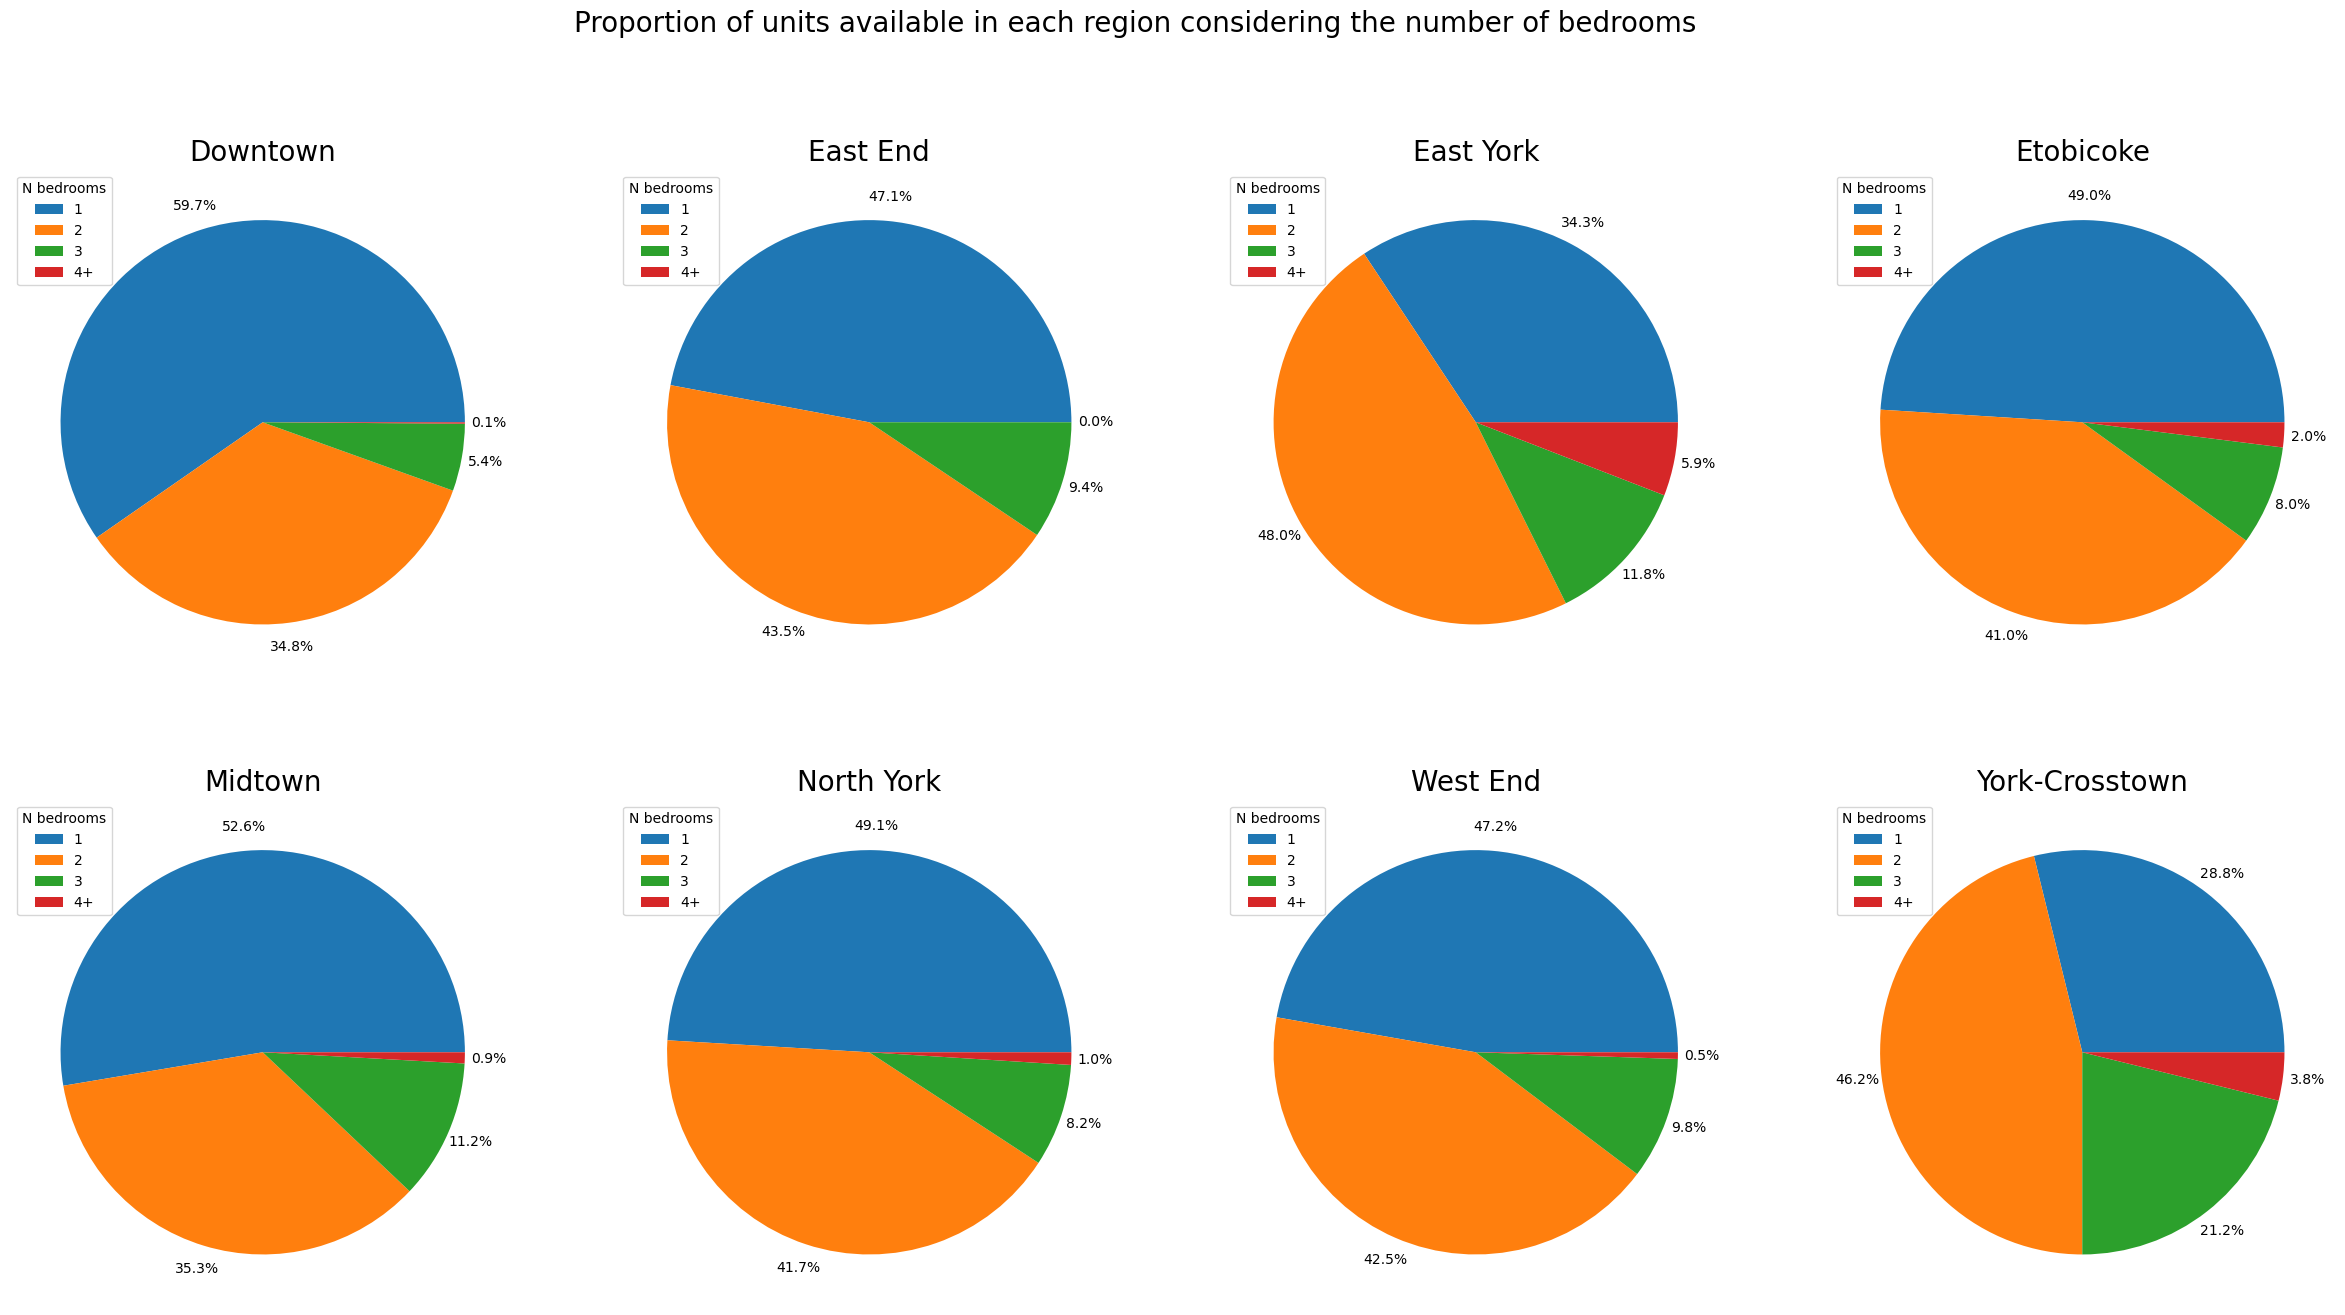

In [203]:
# Group data by number of bedrooms and region

n_bedrooms_and_region = toronto_rentals.groupby(['region', 'bedrooms']).size().unstack(0)

# Plot a pie chart of proportion of units available in each region considering the number of bedrooms

fig, axis = plt.subplots(nrows=2, ncols=4, figsize=(30,15)) # Create subplots

regions_to_plot = n_bedrooms_and_region.columns
region_counter = 0

for i in range(2):
    for y in range(4):
        axis[i][y].pie(n_bedrooms_and_region[regions_to_plot[region_counter]], labels=None, autopct='%1.1f%%', pctdistance=1.12)
        axis[i][y].legend(list(n_bedrooms_and_region[regions_to_plot[region_counter]].index), loc='upper left', title='N bedrooms')
        axis[i][y].set_title(regions_to_plot[region_counter], fontsize=20)
        region_counter += 1

fig.suptitle('Proportion of units available in each region considering the number of bedrooms', fontsize=20)
plt.show() 
fig.savefig('Units availability.png')

C:\Users\Diogo\AppData\Local\Temp\ipykernel_1192\3767947680.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  size_n_bedrooms_and_region = toronto_rentals.groupby(['region', 'bedrooms'], as_index=False).size()


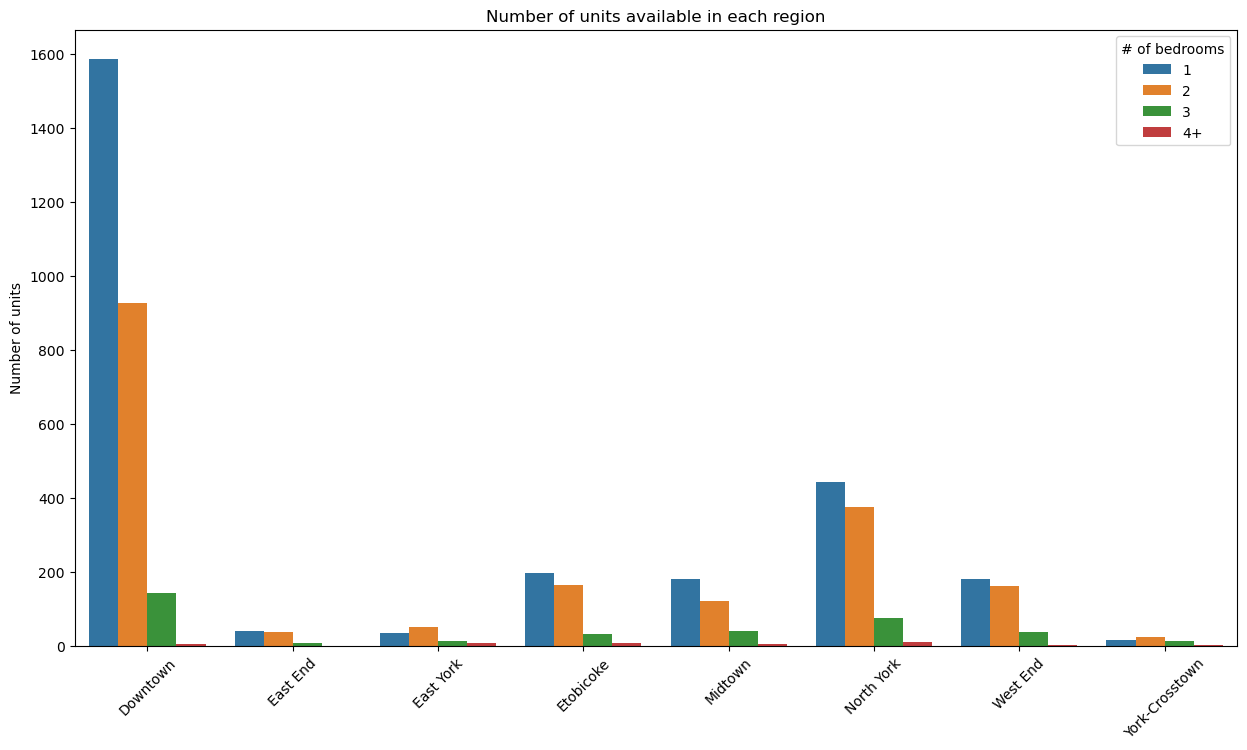

In [204]:
# Group data by number of bedrooms and region

size_n_bedrooms_and_region = toronto_rentals.groupby(['region', 'bedrooms'], as_index=False).size()

# Plot the number of units available in each region considering the number of bedrooms
plt.figure(figsize=(15,8))
sns.barplot(data=size_n_bedrooms_and_region, x='region', y='size', hue='bedrooms')
plt.ylabel('Number of units')
plt.xlabel(None)
plt.xticks(rotation=45)
plt.title('Number of units available in each region')
plt.legend(title='# of bedrooms')
plt.savefig('Number of units available in each region.png');

### Price in each region

C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Text(0.5, 1.0, 'Price distribution per region')

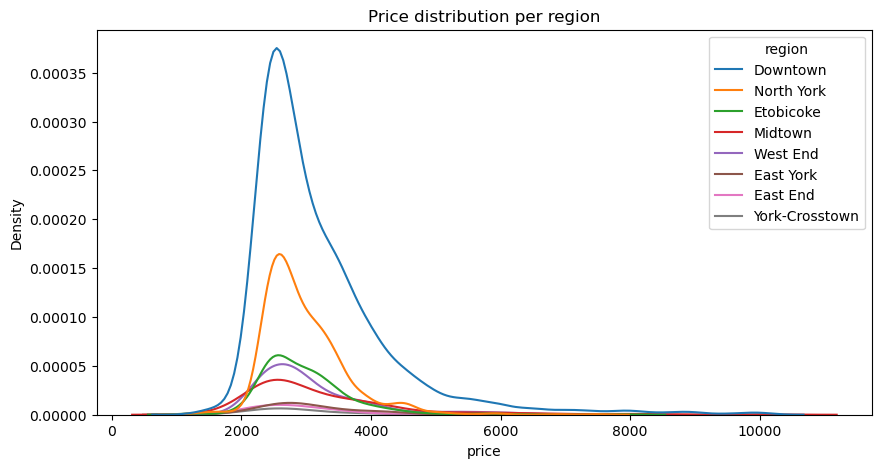

In [206]:
# Distribution of price per region of the city

plt.figure(figsize=(10, 5))
sns.kdeplot(data=toronto_rentals, x='price', hue='region')
plt.title('Price distribution per region')

''

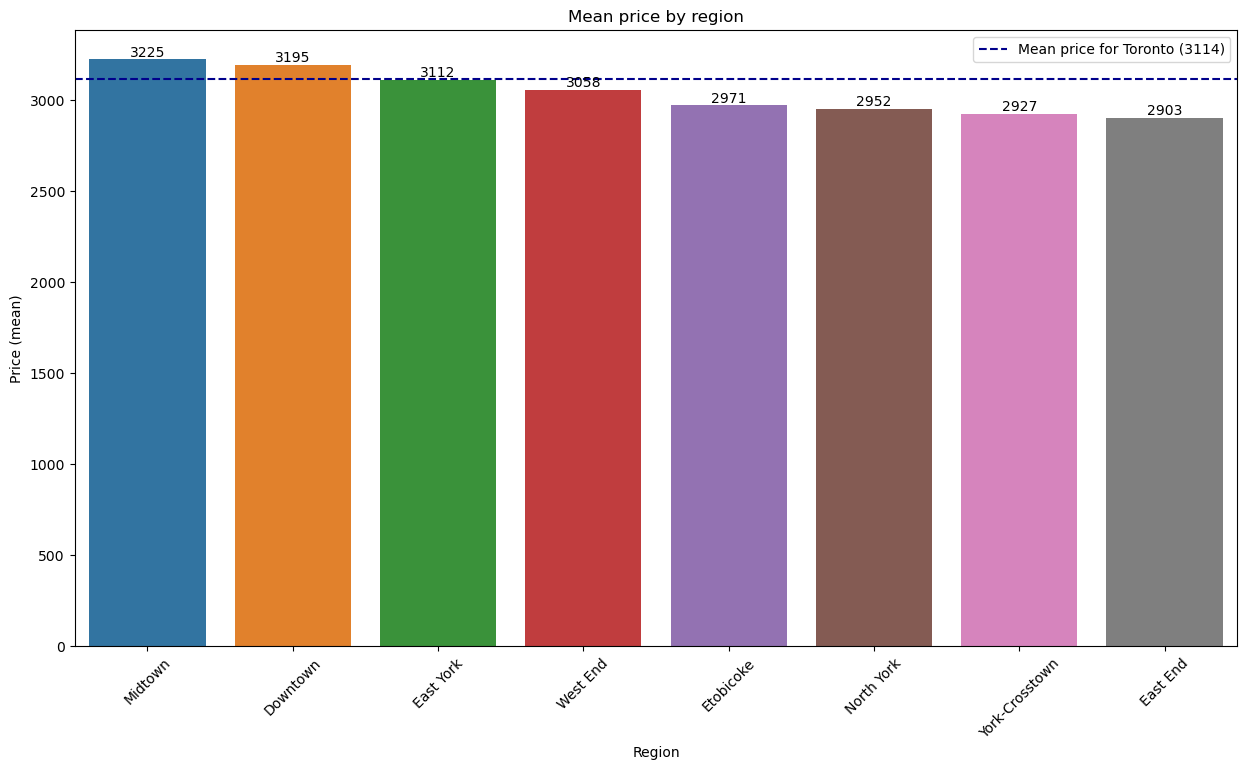

In [207]:
# Mean price per region

# Group data by region and calculate mean price
mean_price_per_region = toronto_rentals.groupby('region', as_index=False)['price'].mean().round(0)

# Sort data by 'price'
mean_price_per_region = mean_price_per_region.sort_values(by='price', ascending=False)

# Plot mean price per region
plt.figure(figsize=(15,8))
ax = sns.barplot(data=mean_price_per_region, x='region', y='price', label='_price')
ax.bar_label(ax.containers[0])
plt.ylabel('Price (mean)')
plt.xlabel('Region')
plt.xticks(rotation=45)
plt.title('Mean price by region');
plt.axhline(y=toronto_rentals['price'].mean(), 
            linestyle='dashed', 
            label=f"Mean price for Toronto ({int(round(toronto_rentals['price'].mean(), 0))})", 
            color='darkblue')
plt.legend()
plt.savefig('Mean price by region.png') # Save the viz locally
;

<Axes: xlabel='size', ylabel='price'>

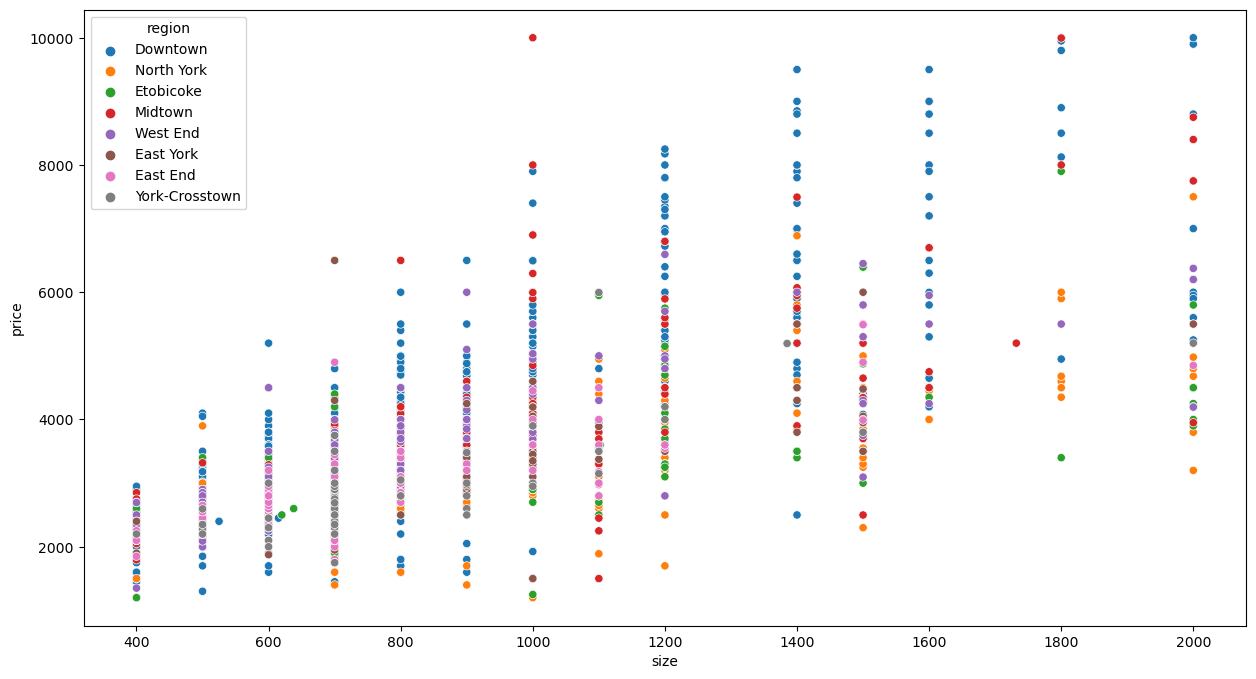

In [208]:
# Price and size per region

plt.figure(figsize=(15, 8))
sns.scatterplot(data=toronto_rentals, x='size', y='price', hue='region')

Midtown have the higher mean price for rent (3225 dollars), followed close by Downton (3195), and East End have the lowest (2903).

However, the mean price might not be the best representation of how expensive one should expect to pay.
To incoporate the variable 'size' as a factor, one could aso look at the price per sqft within a given area. A new feature will be createdtoa measure this value: price_per_sqft.

In [210]:
# Create feature 'price_per_sqft

toronto_rentals['price_per_sqft'] = toronto_rentals['price'] / toronto_rentals['size']

# Check if it worked

toronto_rentals.head()

C:\Users\Diogo\AppData\Local\Temp\ipykernel_1192\1716249041.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  toronto_rentals['price_per_sqft'] = toronto_rentals['price'] / toronto_rentals['size']


,mls,address,price,bathrooms,parking,size,days_since_listed,broker,neighbourhood,city,region,bedrooms,extra_bedroom_spaces,price_per_sqft
0,C9350863,D - 32 Shank St,3500,3,3,1200,0,LIVING REALTY INC.,King West,Toronto,Downtown,2,0,2.92
1,C9347984,3713 - 35 Mercer St,2450,1,1,400,2,PROPERTY.CA INC.,King West,Toronto,Downtown,1,0,6.12
2,C9350769,1508 - 8 Charlotte St,2450,1,1,500,0,LIVING REALTY INC.,King West,Toronto,Downtown,1,0,4.90
3,C9352026,3204 - 327 King St W,2350,1,1,400,0,RE/MAX PLUS CITY TEAM INC.,King West,Toronto,Downtown,1,0,5.88
4,C9351633,1013 - 1030 King St W,3600,2,2,600,0,RE/MAX EXCEL TITAN,King West,Toronto,Downtown,2,0,6.00


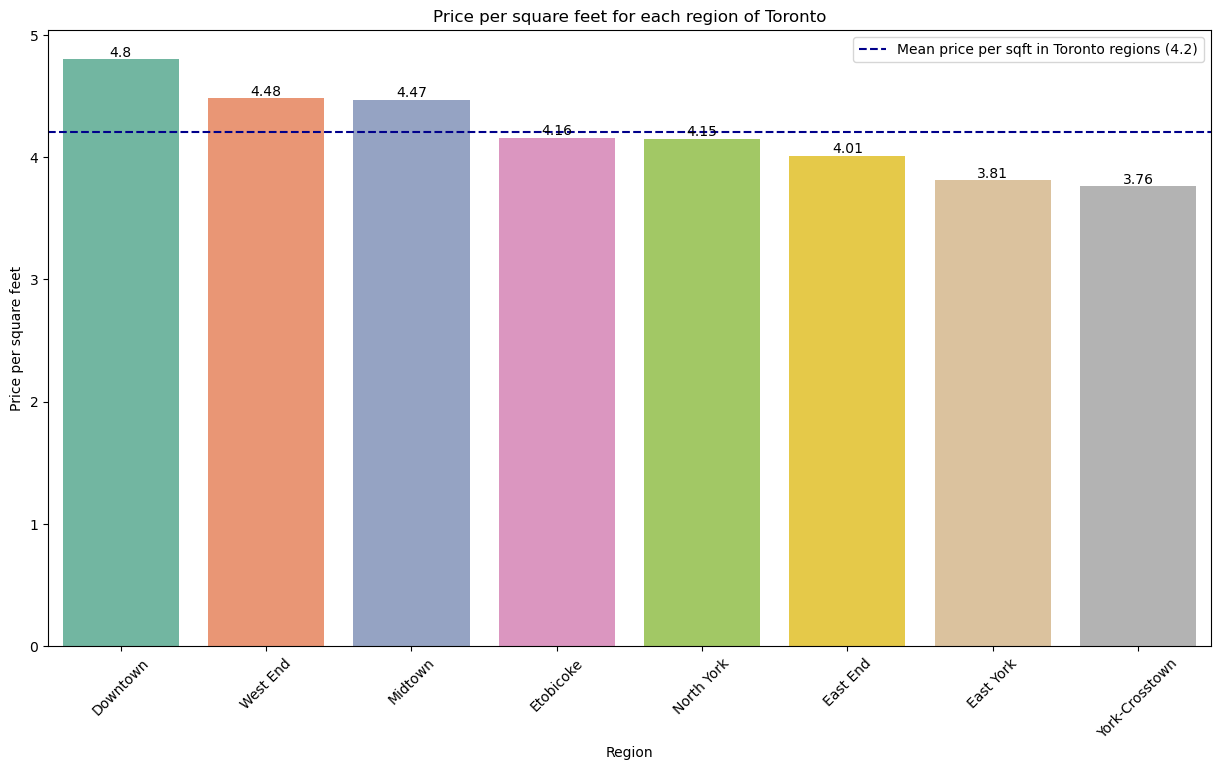

In [211]:
# Mean price_per_sqft per region

# Group data by region
toronto_regions_price_per_sqft = toronto_rentals.groupby('region', as_index=False)['price_per_sqft'].mean().round(2)

# Sort data by 'price_per_sqft'
toronto_regions_price_per_sqft = toronto_regions_price_per_sqft.sort_values(by='price_per_sqft', ascending=False)
toronto_regions_price_per_sqft

#Plot the price_per_sqft per region
plt.figure(figsize=(15, 8))
ax = sns.barplot(data=toronto_regions_price_per_sqft, x='region', y='price_per_sqft', label='_price_per_sqft', palette='Set2')
ax.bar_label(ax.containers[0])
plt.title('Price per square feet for each region of Toronto')
plt.ylabel('Price per square feet')
plt.xlabel('Region')
plt.xticks(rotation=45)
plt.axhline(y=toronto_regions_price_per_sqft['price_per_sqft'].mean(), linestyle='dashed', label=f"Mean price per sqft in Toronto regions ({round(toronto_regions_price_per_sqft['price_per_sqft'].mean(), 2)})", color='darkblue')
plt.legend()
plt.savefig('Price per sqft by region.png')

We can see that the price per square is significantly higher in 'Downtown' (4.8 canadian dollars per square foot) than the other regions. West End comes second (4.48), followed by Midtown (4.47), Etobicoke (4.16), North York (4.15), East End (4.01), East York (3.81) and York-Crosstown (3.76). This is a better reppresentation of purchasing power of one's money in each region when size it taken into account, and using this metric one can evaluate if a particularly unit falls within an expected price for its region.

It also would be interesting to know which would be the most expensive and cheapest neighbourhood in Toronto in terms of price per square feet.

### Most expensive and cheapest regions

''

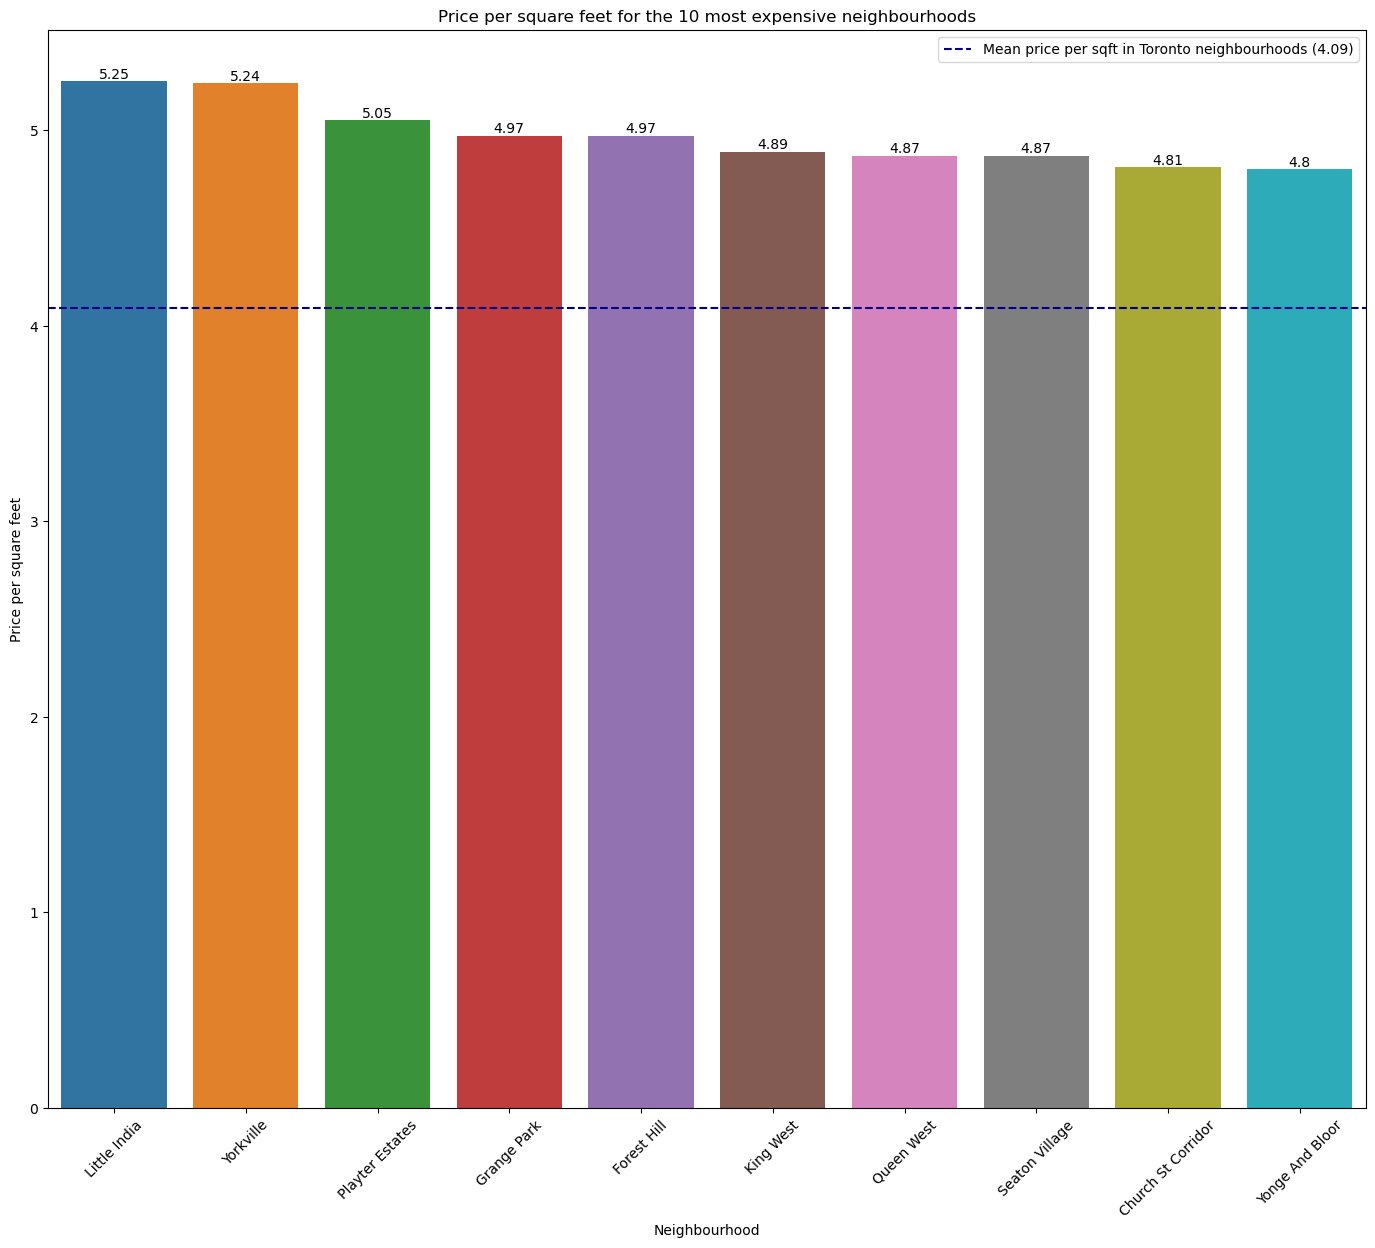

In [398]:
# Mean price per sqft for the 10 most expensive neighbourhoods

# Group data by neighbourhood
toronto_neighbourhood_price_per_sqft = toronto_rentals.groupby('neighbourhood', as_index=False)['price_per_sqft'].mean().round(2)

# Sort data by descending price_per_sqft
toronto_neighbourhood_price_per_sqft = toronto_neighbourhood_price_per_sqft.sort_values(by='price_per_sqft', ascending=False)

# Separate the 10 most expensise
most_expensive_neighbourhoods = toronto_neighbourhood_price_per_sqft.iloc[:10]

#Plot the price_per_sqft per region
plt.figure(figsize=(17, 14))
ax = sns.barplot(data=most_expensive_neighbourhoods, 
                 x='neighbourhood', 
                 y='price_per_sqft', 
                 label='_price_per_sqft')
ax.bar_label(ax.containers[0]) # Add values to the top of each bar
plt.title('Price per square feet for the 10 most expensive neighbourhoods')
plt.ylabel('Price per square feet')
plt.xlabel('Neighbourhood')
plt.xticks(rotation=45)
plt.axhline(y=toronto_neighbourhood_price_per_sqft['price_per_sqft'].mean(), 
            linestyle='dashed', 
            label=f"Mean price per sqft in Toronto neighbourhoods ({round(toronto_neighbourhood_price_per_sqft['price_per_sqft'].mean(), 2)})",
            color='darkblue')
plt.legend()
plt.savefig('Mean price per sqft for most expensive neighbourhoods.png')
;

''

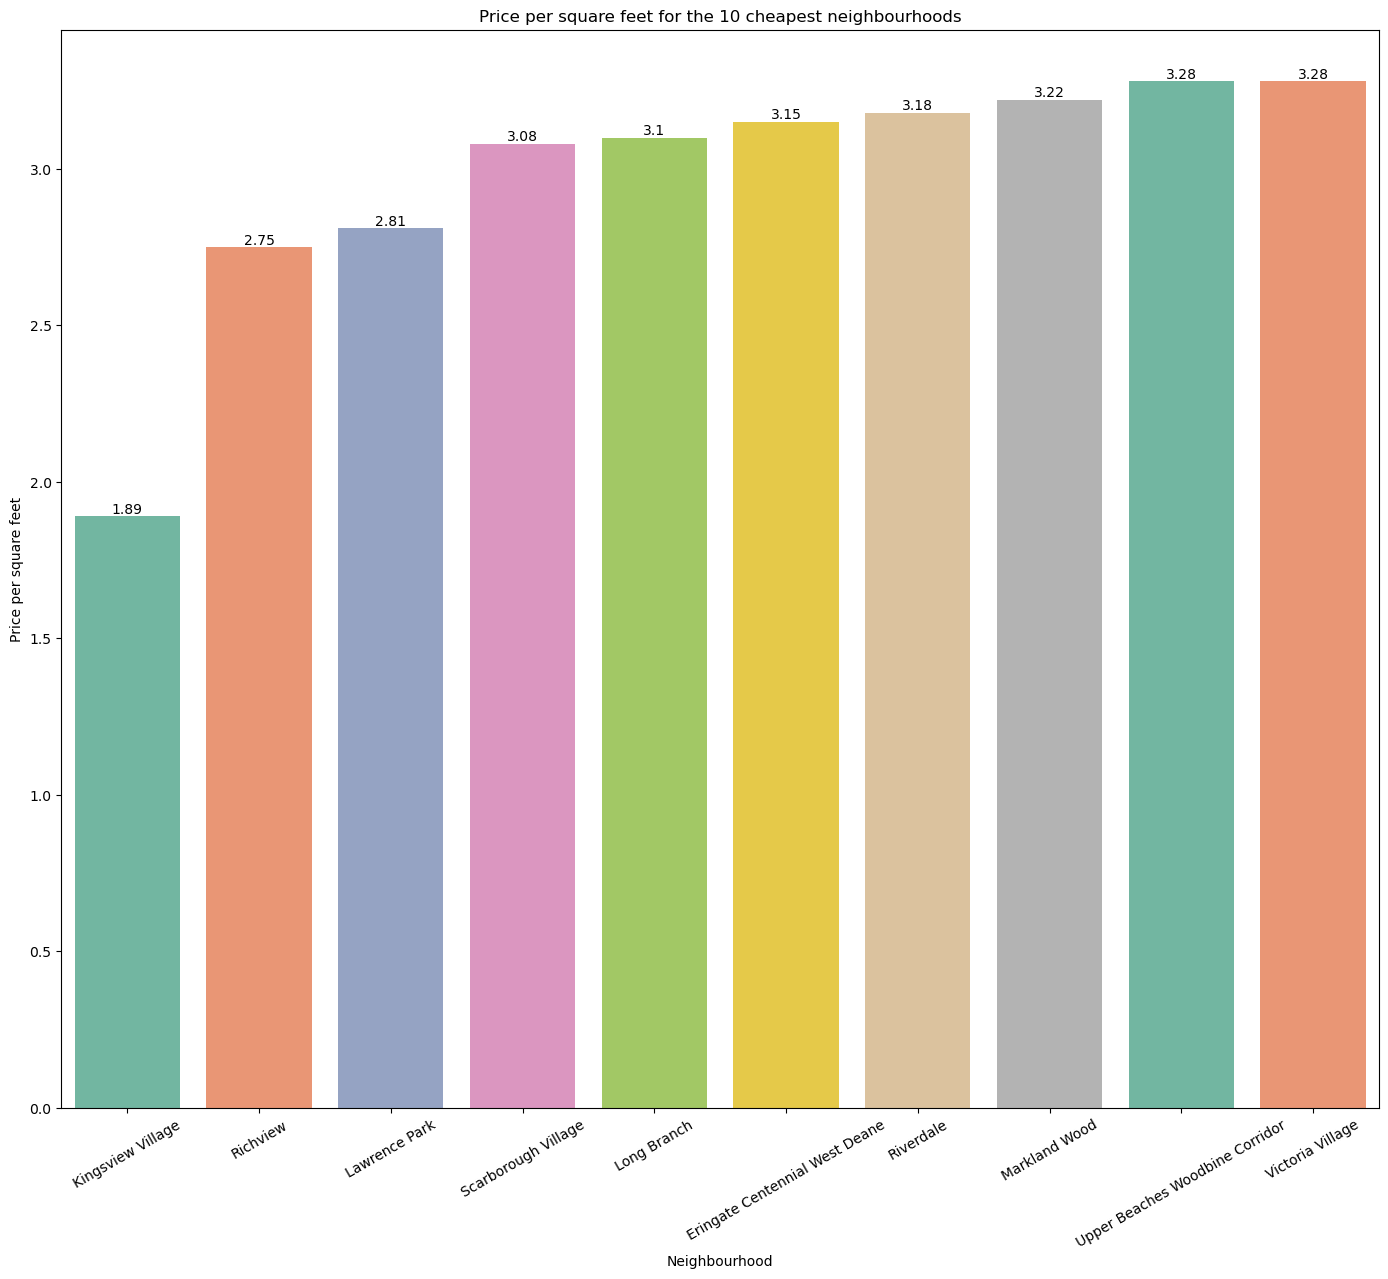

In [396]:
# Mean price per sqft for the 10 cheapest neighbourhoods

# Separate the 10 cheapest neighbourhood from 'toronto_neighbourhood_price_per_sqft'
cheapest_neighbourhoods = toronto_neighbourhood_price_per_sqft.sort_values(by = 'price_per_sqft', ascending=True).iloc[:10]

#Plot the price_per_sqft per region
plt.figure(figsize=(17, 14))
ax = sns.barplot(data=cheapest_neighbourhoods, 
                 x='neighbourhood', 
                 y='price_per_sqft',  
                 palette='Set2',
                 label='_price_per_sqft')
ax.bar_label(ax.containers[0]) # Add values to the top of each bar
plt.title('Price per square feet for the 10 cheapest neighbourhoods')
plt.ylabel('Price per square feet')
plt.xlabel('Neighbourhood')
plt.xticks(rotation=30)
plt.savefig('Mean price per sqft for cheapest neighbourhoods.png')
;

#### Closing remarks

- Size and location seems to play an important role when it comes to renting price.
- As the size of a unit increases, so does its renting price.
- The vast majority of properties in the renting market have one or two bedrooms.
- Some regions of Toronto seem to offer a better price for renting units with more bedrooms (3 bedrooms), such as East York, Etobicoke and York-Crosstown, while Downtown, Midtown and West End seem particularly pricey for these type of properties.
- The mean price per square feet in Toronto is 4.2 canadian dollars. Downtown, West End and Midtown are the only regions where price per square feet is above the mean for the city.
- The 10 most expensive neighbouhoods include Little India, Yorkville, Playter Estates, Grange Park, Forst Hill, King West, Queen West, Seaton Village Church St Corridor, and Yonge and Bloor, with price per square feet range between 5.25 to 4.8 canadian dollars.
- The 10 most cheap neighbourhoods incluce Kingsview Village, Richview Lawrence Park, Scarborough Village, Long Branch, Eringate Centennial West Deane, Riverdale, MarklandWood, Upper Beaches Woodbine Corridor, and Victoria Village, with proce per square feet ranging from 1.89 to 3.28 canadian dollars.
- The metric mean price per square feet highlighted  here could be used as reference for evaluating renting prices withi an given regiosord neighbourhood and help renters to make better deals.